In [1]:
########################## Paper 2 Grid Figure ################################
# The purpose of this script is to make a new grid/study site figure for 
# paper 2 that is a combo of a few different things.
# 
# Notes:
# - This works best in xroms 
###############################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cmocean
from shapely.geometry import Polygon
import os
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LogLocator, LogFormatterExponent, LogFormatterSciNotation, LogFormatter)
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as tick
from matplotlib import cm, ticker
import warnings
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
crs = ccrs.PlateCarree()
warnings.filterwarnings("ignore") #turns off annoying warnings
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])


In [3]:
# set a universal fontsize 
fontsize = 20 # 32 #20

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 12 # 28 # 12
matplotlib.rcParams['ytick.major.pad'] = 12 # 18 # 12

In [4]:
# Load in the model grid
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc') 
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')

# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)
s_rho_len = int(20)

In [5]:
# Load in the initial conditions file
#ini_conds = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Beaufort_Shelf_Rivers_proj_002/Model_Input/Initial_Conds/initial_conds_beaufort_shelf_10rivs_13sections_2020_001.nc') # restrat_mix_ini_kaktovik_biggrid013.nc
ini_conds = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Include/initial_conds_beaufort_shelf_10rivs_13sections_2020_001.nc')

In [6]:
# Add together the percentages of the two mud classes - check this since might need to add more classes together to get full mud fraction...
#tot_mud_percent = ini_conds.mudfrac_01 + ini_conds.mudfrac_02
tot_mud_percent = (ini_conds.mudfrac_01 + ini_conds.mudfrac_02 + ini_conds.mudfrac_03 + ini_conds.mudfrac_04 + ini_conds.mudfrac_05 +
                  ini_conds.mudfrac_06 + ini_conds.mudfrac_07 + ini_conds.mudfrac_08 + ini_conds.mudfrac_09 + ini_conds.mudfrac_10 +
                  ini_conds.mudfrac_11 + ini_conds.mudfrac_12 + ini_conds.mudfrac_13 + ini_conds.mudfrac_14)

# Make it so land can be masked easily 
# Make it so land will be gray
temp_mask = grid.mask_rho.values
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)
# mud01
tot_mud_percent_wland = tot_mud_percent * temp_mask

# Add together the percentages of the two mud classes
tot_sand_percent = ini_conds.sandfrac_01 + ini_conds.sandfrac_02

# Make it so land can be masked easily 
# Make it so land will be gray
temp_mask = grid.mask_rho.values
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)
# mud01
tot_sand_percent_wland = tot_sand_percent * temp_mask
#tot_sand_percent_wland = tot_sand_percent_wland.fillna(-1)

In [7]:
# ------ Masking -----
# Make functions to help with masking 
# Make masks to isolate each region, starting with breaking things up by depth 
# Make a function to mask the data
def masked_array(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data <= threshold).astype(int)

# Make a function to mask the data but that takes two thresholds
def masked_array_lowhigh_2dloop(data, lower, upper):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    mask_tmp = np.empty_like((data))
    
    # Loop through dimension 1
    for i in range(len(data[:,0])):
        # Loop through dimension 2
        for j in range(len(data[0,:])):
            # Compare against threshold 
            value = data[i,j]
            if lower < value <= upper:
                mask_tmp[i,j] = 1
            else:
                mask_tmp[i,j] = 0
    
    
    return (mask_tmp).astype(int)

# Make a function to mask the data - higher
def masked_array_higher(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data >= threshold).astype(int)

In [8]:
# Make the masks to partition the seabed into different regions 

# Call the function to make the mask
# Leave in the region that is nudged/past the slope since we will need 
# to put sediment there regardless

# 0 - 10 m 
h_masked1 = grid.h.copy()
mask_0_10m_rho = masked_array_lowhigh_2dloop(h_masked1, 0, 10)

# 10 - 30 m
h_masked2 = grid.h.copy()
mask_10_30m_rho = masked_array_lowhigh_2dloop(h_masked2, 10, 30)

# 30 - 60 m
h_masked3 = grid.h.copy()
mask_30_60m_rho = masked_array_lowhigh_2dloop(h_masked3, 30, 60)

# > 60 m 
h_masked4 = grid.h.copy()
mask_60_end_rho = masked_array_lowhigh_2dloop(h_masked4, 60, 2200)


# Partition the seabed into the different regions 

# Make the nearshore sections 
mask_0_10m_rho_plot2 = mask_0_10m_rho.copy()
idx_ones_0_10m2 = np.where(mask_0_10m_rho_plot2 == 1)
# Set everywhere it is 1 equal to 2 
#mask_0_10m_rho_plot2[idx_ones_0_10m2] = 2
# Make an empty list to hold the indices for center
idx_ones_0_10m_far_left_etas = []
idx_ones_0_10m_far_left_xis = []
idx_ones_0_10m_center_left_etas = []
idx_ones_0_10m_center_left_xis = []
idx_ones_0_10m_center_right_etas = []
idx_ones_0_10m_center_right_xis = []
idx_ones_0_10m_far_right_etas = []
idx_ones_0_10m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_0_10m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_0_10m2[0][i]
    xi_tmp = idx_ones_0_10m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_0_10m_far_left_etas.append(eta_tmp)
        idx_ones_0_10m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    elif 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_left_etas.append(eta_tmp)
        idx_ones_0_10m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    elif 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_right_etas.append(eta_tmp)
        idx_ones_0_10m_center_right_xis.append(xi_tmp)
        # Check if this is in the far right range
    elif xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_far_right_etas.append(eta_tmp)
        idx_ones_0_10m_far_right_xis.append(xi_tmp)

# Make this 3 for center and 4 for right
mask_0_10m_rho_plot2[idx_ones_0_10m_far_left_etas[:],idx_ones_0_10m_far_left_xis[:]] = 2
mask_0_10m_rho_plot2[idx_ones_0_10m_center_left_etas[:],idx_ones_0_10m_center_left_xis[:]] = 3
mask_0_10m_rho_plot2[idx_ones_0_10m_center_right_etas[:],idx_ones_0_10m_center_right_xis[:]] = 4
mask_0_10m_rho_plot2[idx_ones_0_10m_far_right_etas[:],idx_ones_0_10m_far_right_xis[:]] = 5



# Make the middle sections 
mask_10_30m_rho_plot2 = mask_10_30m_rho.copy()
idx_ones_10_30m2 = np.where(mask_10_30m_rho_plot2 == 1)
# Set everything in here equal to 5 
#mask_10_30m_rho_plot2[idx_ones_10_30m2] = 5
# Make an empty list to hold the indices for center
idx_ones_10_30m_far_left_etas = []
idx_ones_10_30m_far_left_xis = []
idx_ones_10_30m_center_left_etas = []
idx_ones_10_30m_center_left_xis = []
idx_ones_10_30m_center_right_etas = []
idx_ones_10_30m_center_right_xis = []
idx_ones_10_30m_far_right_etas = []
idx_ones_10_30m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_10_30m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_10_30m2[0][i]
    xi_tmp = idx_ones_10_30m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_10_30m_far_left_etas.append(eta_tmp)
        idx_ones_10_30m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_left_etas.append(eta_tmp)
        idx_ones_10_30m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_right_etas.append(eta_tmp)
        idx_ones_10_30m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_far_right_etas.append(eta_tmp)
        idx_ones_10_30m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_10_30m_rho_plot2[idx_ones_10_30m_far_left_etas[:],idx_ones_10_30m_far_left_xis[:]] = 6
mask_10_30m_rho_plot2[idx_ones_10_30m_center_left_etas[:],idx_ones_10_30m_center_left_xis[:]] = 7
mask_10_30m_rho_plot2[idx_ones_10_30m_center_right_etas[:],idx_ones_10_30m_center_right_xis[:]] = 8
mask_10_30m_rho_plot2[idx_ones_10_30m_far_right_etas[:],idx_ones_10_30m_far_right_xis[:]] = 9



# Make the outer sections
mask_30_60m_rho_plot2 = mask_30_60m_rho.copy()
idx_ones_30_60m2 = np.where(mask_30_60m_rho_plot2 == 1)
# Set everything in here equal to 8
#mask_30_60m_rho_plot2[idx_ones_30_60m2] = 8
# Make an empty list to hold the indices for center
idx_ones_30_60m_far_left_etas = []
idx_ones_30_60m_far_left_xis = []
idx_ones_30_60m_center_left_etas = []
idx_ones_30_60m_center_left_xis = []
idx_ones_30_60m_center_right_etas = []
idx_ones_30_60m_center_right_xis = []
idx_ones_30_60m_far_right_etas = []
idx_ones_30_60m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_30_60m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_30_60m2[0][i]
    xi_tmp = idx_ones_30_60m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 186:
        idx_ones_30_60m_far_left_etas.append(eta_tmp)
        idx_ones_30_60m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 186 <= xi_tmp < 320:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_left_etas.append(eta_tmp)
        idx_ones_30_60m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 320 <= xi_tmp < 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_right_etas.append(eta_tmp)
        idx_ones_30_60m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 466:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_far_right_etas.append(eta_tmp)
        idx_ones_30_60m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_30_60m_rho_plot2[idx_ones_30_60m_far_left_etas[:],idx_ones_30_60m_far_left_xis[:]] = 10
mask_30_60m_rho_plot2[idx_ones_30_60m_center_left_etas[:],idx_ones_30_60m_center_left_xis[:]] = 11
mask_30_60m_rho_plot2[idx_ones_30_60m_center_right_etas[:],idx_ones_30_60m_center_right_xis[:]] = 12
mask_30_60m_rho_plot2[idx_ones_30_60m_far_right_etas[:],idx_ones_30_60m_far_right_xis[:]] = 13



# Make the outest section
mask_60_end_rho_plot2 = mask_60_end_rho.copy()
idx_ones_60_end2 = np.where(mask_60_end_rho_plot2 == 1)
# Set everything in here equal to 8
mask_60_end_rho_plot2[idx_ones_60_end2] = 14

# Add in the nudged sections to the last group = 14
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36
# Make these regions 14
mask_0_10m_rho_plot2[:,:c_west] = 14
mask_0_10m_rho_plot2[:,-c_west:] = 14
mask_10_30m_rho_plot2[:,:c_west] = 14
mask_10_30m_rho_plot2[:,-c_west:] = 14
mask_30_60m_rho_plot2[:,:c_west] = 14
mask_30_60m_rho_plot2[:,-c_west:] = 14
mask_60_end_rho_plot2[:,:c_west] = 14
mask_60_end_rho_plot2[:,-c_west:] = 14

In [9]:
# Things to prep for plotting 

# Set the thickness of sponge
c_west = 36
c_north = 45
c_east = 36

# Make list of colors to use for plots
seabed_section_colors = ['#D1C8FB', '#F4B6D3', '#FFC8B0', '#FFE3B2', '#A190F4', 
                         '#E86DA6', '#FF925F', '#FFC863', '#785EF0', '#DC267F', 
                         '#FF6100', '#FFB000','#6490FF']
#river_marker_colors = ['#FC440F', '#00A6A6', '#5EF38C', '#26532B', '#0115F5',
               #        '#9C00A8', '#F43ECF', '#F5ED00']
river_marker_colors = ['#FC440F', '#F5ED00', '#5EF38C', '#26532B', '#F43ECF', '#9C00A8',
                       '#0115F5', '#00A6A6', '#AB64EB', '#D44179', '#08E0E3', '#B27009', '#EA8D40']

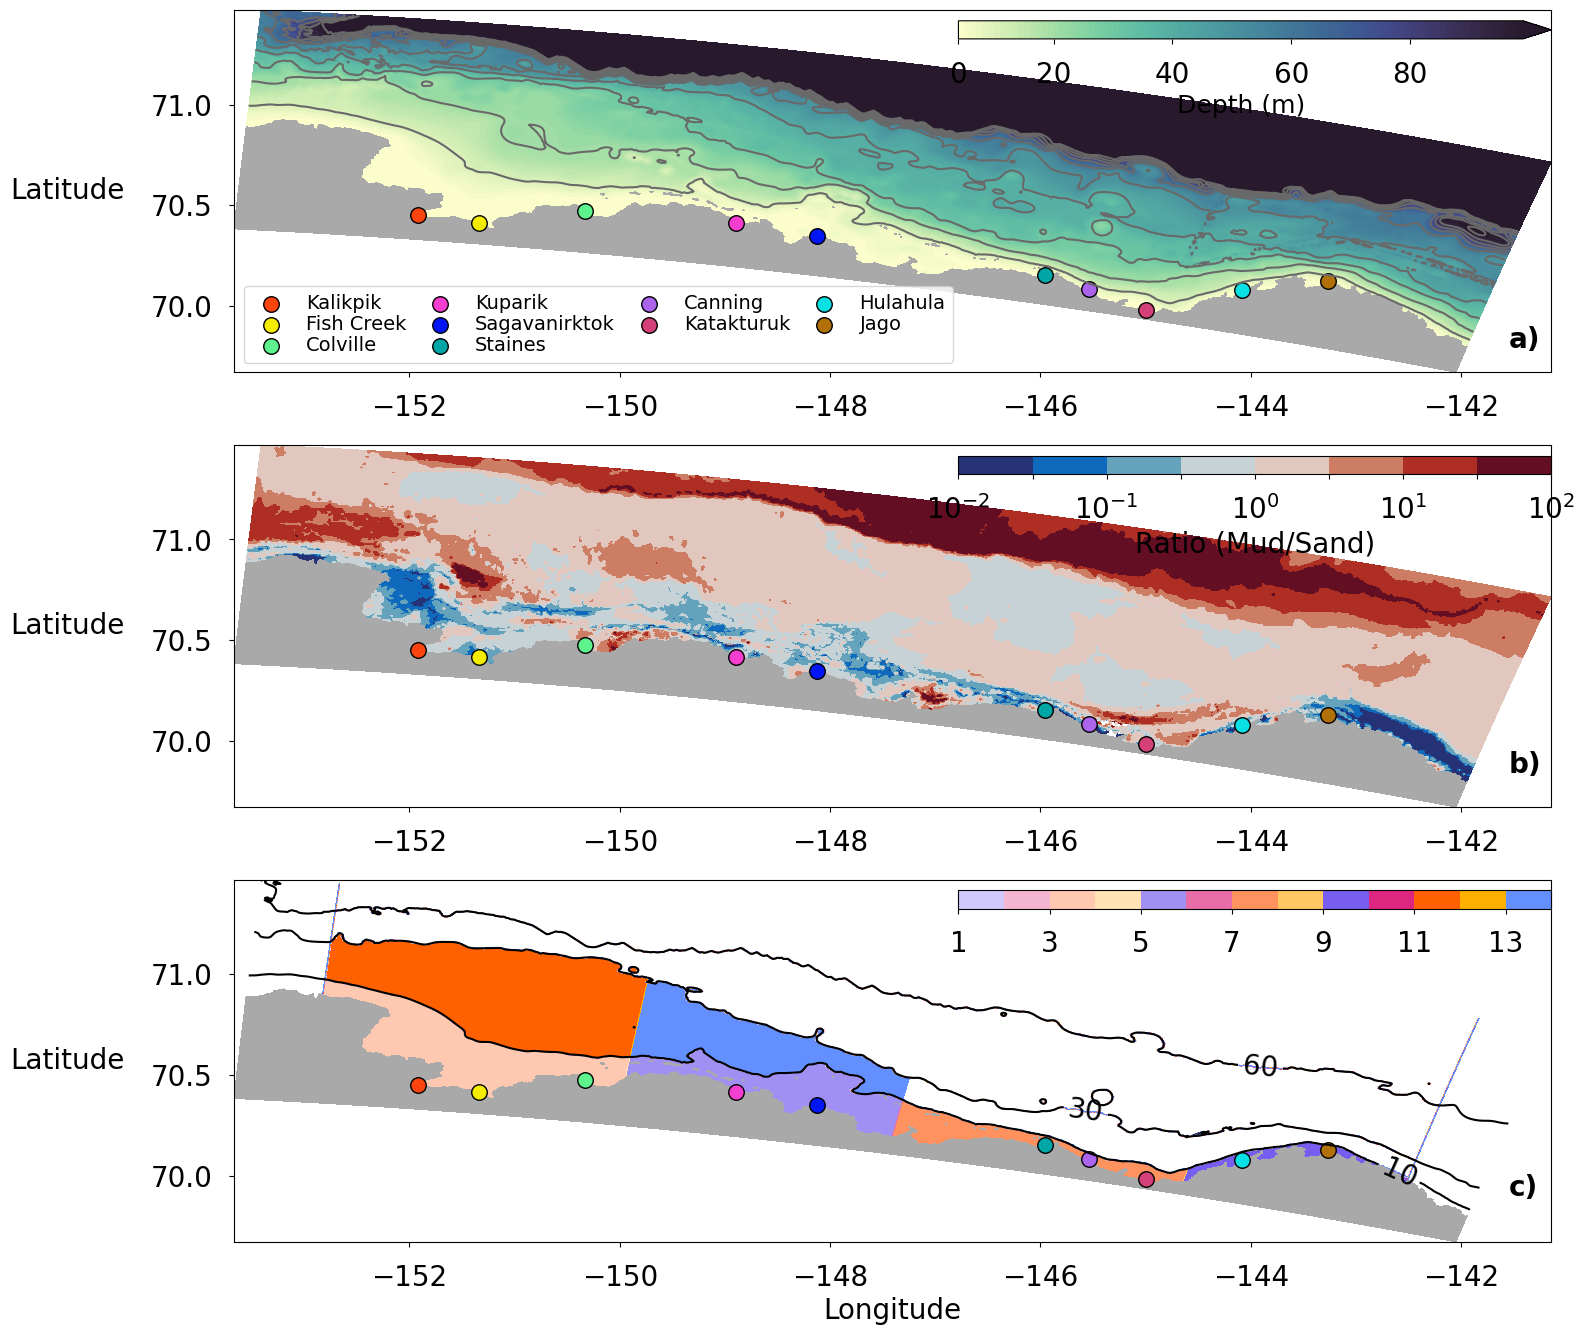

In [10]:
# -----------------------------------------------------------
# ------ Plot 1: Subplot of two figures from above ------
# -------------------------------------------------------------
# Make a subplot with the two figures from above together as 
# one figure (for the paper). Remove the title and have them share
# the colorbar and make a few other edits from other version
# (15,30)

# Determine spacing of contours
cmap7 = cmocean.cm.deep
lev6 = np.arange(grid.h.values.min()-1, 100, 1)
lev7 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Plot land as gray 
# Make reverse mask so land can be gray 
reverse_colors = colors.ListedColormap(['darkgray','#FF000000'])
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, reverse_colors.N)
# Make new mask so land is gray - NEW
mask_rho2 = grid.mask_rho.values
mask_rho2[mask_rho2==1.0] = 2.0

# Make the figure
fig1, ax1 = plt.subplots(3, figsize=(17,16)) # (width, height), (15, 12) for horizontal colorbar; (20, 16) for vertical colorbaroutside plots

# ----- Top Subplot: Bathymetry and Rivers -----
# --- Bottom subplot - Rivers ---
# Plot the bathymetry\
cs8 = ax1[0].contourf(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev6, cmap=cmap7, extend='max')
cs9 = ax1[0].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray')

# Plot land as gray 
cs0g = ax1[0].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)


# Plot the 14 rivers in the grid
# Go from West to East
# Kalikpik River
eta_kal_idx = 23 #22
xi_kal_idx = 87
s1 = ax1[0].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

# Fish Creek
eta_fis_idx = 20
xi_fis_idx = 117 #116
s2 = ax1[0].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

# Colville River
eta_col_idx = 39
xi_col_idx = 166 #166
s3 = ax1[0].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

# Sakonowyak River
eta_sak_idx = 46 #45
xi_sak_idx = 234
#s4 = ax11.scatter(x_rho_flat[xi_sak_idx]/1000, y_rho_flat[eta_sak_idx]/1000, 
 #           marker='.', s=500, linewidth=1, edgecolors='black', color='green', label='Sakonowyak')

# Kuparik
# Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
# of the Kuparuk River
eta_kuk_idx = 41 #40
xi_kuk_idx = 239
eta_kup_idx = 41 #40
xi_kup_idx = 242
s5 = ax1[0].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')


# Putuligayuk River
eta_put_idx = 28 #27
xi_put_idx = 264
#s8 = ax11.scatter(x_rho_flat[xi_put_idx]/1000, y_rho_flat[eta_put_idx]/1000, 
 #           marker='1', s=500, linewidth=1, edgecolors='black', color='dodgerblue', label='Putuligayuk')

# Sagavanirktok River
eta_sag_idx = 37 #36
xi_sag_idx = 279
s9 = ax1[0].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

# Canning River
# Staines River
eta_sta_idx = 27 #26
xi_sta_idx = 393
s10 = ax1[0].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

# Canning River
eta_can_idx = 20 #19
xi_can_idx = 416
s11 = ax1[0].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

# Katakturuk River
eta_kat_idx = 9 #8
xi_kat_idx = 447
s12 = ax1[0].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

# Hulahula River
eta_hul_idx = 40
xi_hul_idx = 489
s13 = ax1[0].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

# Jago River
eta_jag_idx = 62 #61
xi_jag_idx = 528
s14 = ax1[0].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')

# Siksik River
eta_sik_idx = 46
xi_sik_idx = 574 #573
#s15 = ax11.scatter(x_rho_flat[xi_sik_idx]/1000, y_rho_flat[eta_sik_idx]/1000, 
 #           marker='.', s=300, linewidth=4, color='deeppink', label='Siksik')

# Temporary not too bad legend
ax1[0].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)

# Format axes
#ax1[0].set_xlabel('Longitude (degrees)', fontsize=fontsize)
ax1[0].set_ylabel('Latitude \n(degrees)', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118

# Specify colorbar
#cbar3 = fig3.colorbar(cs6, label='Depth (m)', orientation='vertical', ax=ax3)
#cbar3.set_label(label='Depth (meters)', size=fontsize)
# If horizontal and in axes
cbar5 = plt.colorbar(cs8, cax=ax1[0].inset_axes((0.55, 0.92, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
                     ticks=[0, 20, 40, 60, 80], ax=ax1[0], 
                     orientation='horizontal').set_label(label='Depth (m)', size=fontsize-2)

# Label subplots
# put labels in top right corners
#plt.text(0.715, 0.853, 'a)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
#plt.text(0.715, 0.442, 'b)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
# put labels in bottom right corners
#plt.text(0.870, 0.553, 'a)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
#plt.text(0.870, 0.142, 'b)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)






# ----- Middle Subplot: Fraction of Mud/Sand -----

# Determine spacing of contours
lev7 = np.arange(-0.00001, 1, 0.01)
cmap4 = cmocean.cm.turbid
cmap4.set_under('darkgray')

lev8 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

lev9 = np.arange(0,2,0.01)

# Plot bathymetry contours
# Plot the bathymetry
cs9 = ax1[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray')
# Plot land as gray 
cs0g = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)

#cs10 = ax1[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values*grid.mask_rho.values, lev8, colors='dimgray')

# Plot the percent mud
#cs11 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_mud_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Mud')

# Plot the percent sand
#cs12 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_sand_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Sand')

# Plot the ratio 
cmap5 = cmocean.cm.balance
cmap5.set_under('darkgray')
cmap5.set_bad('darkgray')

ratio_mud_over_sand = (tot_mud_percent_wland/tot_sand_percent_wland)

# Get rid of zeros before logging
no_inf1 = np.where(ratio_mud_over_sand == 0, 10**-1.5, ratio_mud_over_sand)

# Mask land
#ratio_mud_over_sand_wland = ratio_mud_over_sand * temp_mask
ratio_mud_over_sand_wland = no_inf1 * temp_mask
#input('press enter...')

# Get rid of nans
#ratio_mud_over_sand_wland = ratio_mud_over_sand_wland.fillna(-1.5)

# Get rid of infinity 
no_inf2 = np.where(ratio_mud_over_sand_wland == np.inf, 40, ratio_mud_over_sand_wland)

# No log scale
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, ratio_mud_over_sand_wland[0,0,:,:], lev9,
 #                     cmap=cmap5, extend='both', label='Ratio')
 
# Log of actual values
lev13 = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
log_ratio = np.log10(no_inf2[0,0,:,:])
log_ratio2 = np.nan_to_num(log_ratio, nan=-3)
# Works but might be wrong since real values are -2 to 2
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, log_ratio2, 
 #                     lev13, cmap=cmap5,  vmin=-2.0, vmax=2.0, extend='both', label='Ratio')
# Try plotting just the ratio but on a log scale 
lev13b = [10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 10**(0), 10**(0.5), 10**(1), 10**(1.5), 10**(2)]
cs13 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, no_inf2[0,0,:,:], 
                      lev13b, cmap=cmap5, locator=LogLocator(base=10), vmin=10**(-2), 
                      vmax=10**(2), label='Ratio')

# Add title
#ax3.set_title('Mud and Sand Fraction', fontsize=30, y=1.08)
#ax1[1].set_title('Ratio (Mud/Sand)', fontsize=fontsize)

# Log scale
# Data as log
cbar5 = fig1.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax1[1], 
                      cax=ax1[1].inset_axes((0.55, 0.92, 0.45, 0.05)), extend='both')
cbar5.set_label(label='Ratio (Mud/Sand)', size=fontsize)


# Plot the 14 rivers in the grid
# Go from West to East
# Kalikpik River
s1 = ax1[1].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

# Fish Creek
s2 = ax1[1].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

# Colville River
s3 = ax1[1].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

# Kuparik
# Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
# of the Kuparuk River
s5 = ax1[1].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')


# Sagavanirktok River
s9 = ax1[1].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

# Canning River
# Staines River
s10 = ax1[1].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

# Canning River
s11 = ax1[1].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

# Katakturuk River
s12 = ax1[1].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

# Hulahula River
s13 = ax1[1].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

# Jago River
s14 = ax1[1].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')





# ----- Bottom Subplot: Seabed sections from Methods -----

# Plot all of this mayhem
# Make a fake xy with the right resolution to be able to plot without the angle
x_rho_flat = np.arange(0,750*len(grid.x_rho[0,:]),750)
y_rho_flat = np.arange(0,600*len(grid.y_rho[:,0]),600)
# Prep the data by  ultiplying by the mask and trimming
# Trim 
x_rho_flat_trimmed = x_rho_flat[c_west:-c_west]

# Set the fontsize 
fontsize = 20

# Set the levels 
lev11 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# Set the colormap
#cmap11 = cm.get_cmap('tab20', 14)
#cmap11.set_under(color='darkgrey')
cmap11 = LinearSegmentedColormap.from_list('seabed_sections', colors=seabed_section_colors, N=13)
#cmap11.set_under(color='darkgrey')

# Plot the bathymetry
cs11 = ax1[2].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h.values, levels=[10,30,60], 
            colors='black', label=True)
ax1[2].clabel(cs11, inline=True, fontsize=20)

# Plot region 1 [0 - 10 m, across all longitudes]
cp37 = ax1[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_0_10m_rho_plot2*grid.mask_rho.values, 
                   lev11, cmap=cmap11)

# Plot region 2 [10 - 30 m, across all longitudes]
cp38 = ax1[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_10_30m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 3 [30 - 60 m, across all longitudes]
cp39 = ax1[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_30_60m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 4 [60 - end, across all longitudes]
cp40 = ax1[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_60_end_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot land as gray 
cs0g = ax1[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)

# Make the colorbar (numbers/values mean the region)
cbar11 = plt.colorbar(cp37, ax=ax1[2], extend='both', cmap=cmap11, orientation='horizontal', 
                      cax=ax1[2].inset_axes((0.55, 0.92, 0.45, 0.05)))

# Plot the 14 rivers in the grid
# Go from West to East
# Kalikpik River
s1 = ax1[2].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

# Fish Creek
s2 = ax1[2].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

# Colville River
s3 = ax1[2].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

# Kuparik
# Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
# of the Kuparuk River
s5 = ax1[2].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')

# Sagavanirktok River
s9 = ax1[2].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

# Canning River
# Staines River
s10 = ax1[2].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

# Canning River
s11 = ax1[2].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

# Katakturuk River
s12 = ax1[2].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

# Hulahula River
s13 = ax1[2].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

# Jago River
s14 = ax1[2].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')


# Temporary not too bad legend
#ax1[2].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.1, labelspacing=0.1)

# Label the axes
ax1[0].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax1[1].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax1[2].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax1[2].set_xlabel('Longitude', fontsize=fontsize)


plt.text(0.875, 0.669, 'a)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.875, 0.403, 'b)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.875, 0.139, 'c)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)






# Find plots of certain characteristics and add them
# as subplot to the above plot

# Distance between land and 10 m isobath at each longitude

# In grid, loop through each xi_rho, then find distance between first cell 
# that is 1 in eta-direction and first cell in eta direction that is >= 10 m in h

# Make triggers 
if1 = 0
if2 = 0

# Make empty array to hold distances
dist_to_10m = np.empty_like((grid.xi_rho))

# Loop through xi
for i in range(len(grid.xi_rho)):
    #print('i: ', i)
    
    # Loop through eta
    for j in range(len(grid.eta_rho)):
        
        # Find the first spot that has mask_rho = 1
        if grid.mask_rho[j,i].values == 2.0 and if1 == 0:
            #print('found 1 in mask at eta: ' + str(j) + ', xi: ' + str(i))
            
            j_land = j
            if1 = 1
        
        # Find the first spot that has bathyemtry >=10 
        if grid.h[j,i].values >= 10.0 and if2 == 0:
            #print('found 10 m bathymetry at eta: ' + str(j) + ', xi: ' + str(i))
            
            j_10m = j
            if2 = 1
    
    
    
    # Calculate the index distance in these two values
    j_diff = j_10m - j_land
    
    #print('j_diff: ', j_diff)
    
    # Make this a physical distance 
    j_diff_m = j_diff * 600 # meters
    
    #print('j_diff_m: ', j_diff_m)
    
    # Save this to the array
    dist_to_10m[i] = j_diff_m
    
    # Reset ifs
    if1 = 0
    if2 = 0
    
    #input('press enter to continue...')

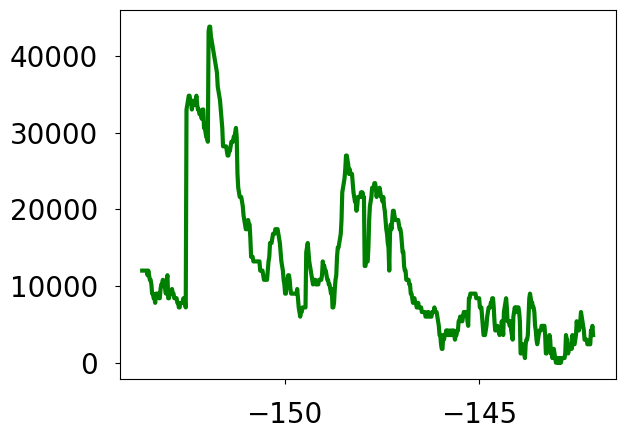

In [11]:

# Now make a plot of this just to see
fig2, ax2 = plt.subplots()
ax2.plot(grid.lon_rho[0,:].values, dist_to_10m, color='green', linewidth=3)

Text(0.875, 0.139, 'd)')

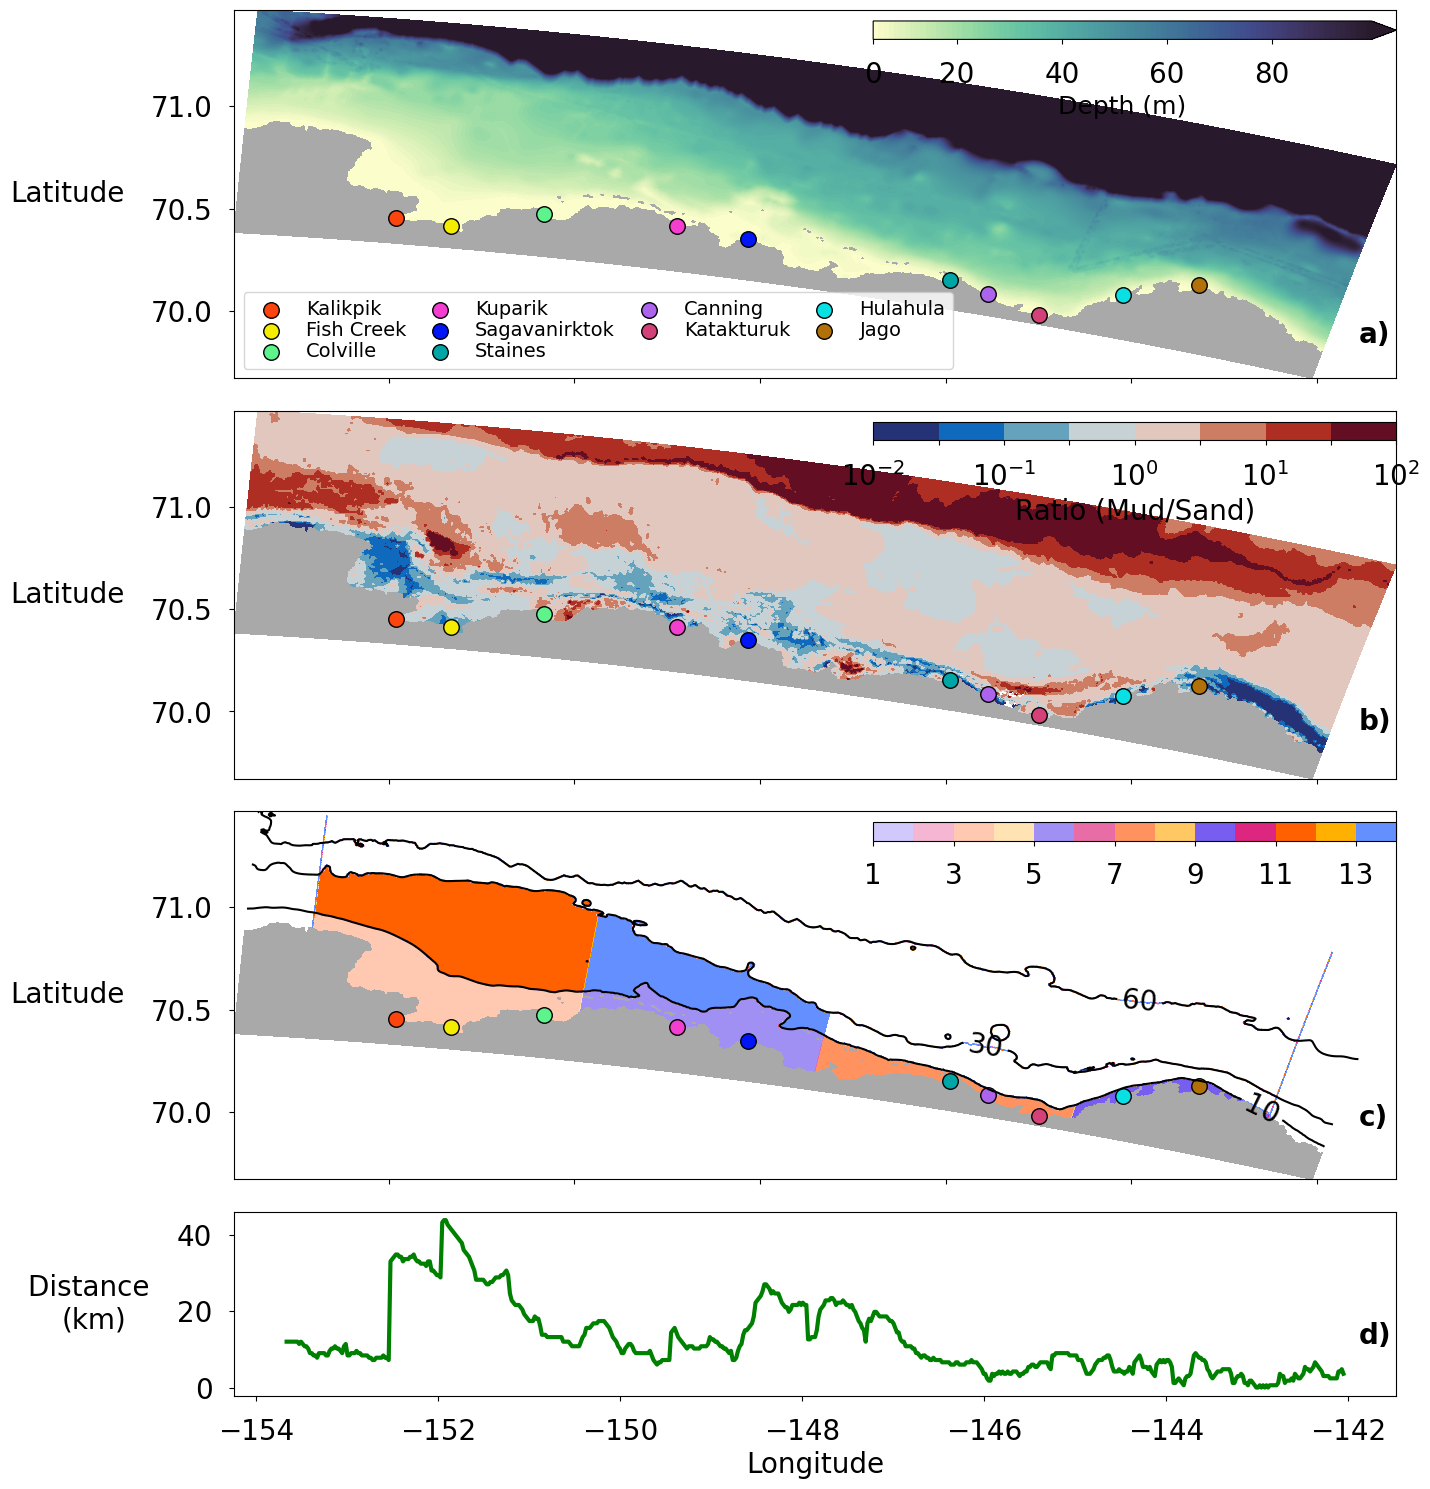

In [12]:
# Now make a version of the plot above with this added on as a subplot

# -----------------------------------------------------------
# ------ Plot 2: Subplot of two figures from above ------
# --------- with distance to 10 m isobath ---------------------
# -------------------------------------------------------------
# Make a subplot with the two figures from above together as 
# one figure (for the paper). Remove the title and have them share
# the colorbar and make a few other edits from other version
# (15,30)


# Make the figure
fig2, ax2 = plt.subplots(4, figsize=(15,18), gridspec_kw={'height_ratios': [1, 1, 1, 0.5]}) # (width, height), (15, 12) for horizontal colorbar; (20, 16) for vertical colorbaroutside plots

# ----- Top Subplot: Bathymetry and Rivers -----
# --- Bottom subplot - Rivers ---
# Plot the bathymetry\
cs8 = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev6, cmap=cmap7, extend='max')
cs9 = ax2[0].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray')

# Plot land as gray 
cs0g = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)

# Format axes
#ax1[0].set_xlabel('Longitude (degrees)', fontsize=fontsize)
ax2[0].set_ylabel('Latitude \n(degrees)', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118

# Specify colorbar
#cbar3 = fig3.colorbar(cs6, label='Depth (m)', orientation='vertical', ax=ax3)
#cbar3.set_label(label='Depth (meters)', size=fontsize)
# If horizontal and in axes
cbar5 = plt.colorbar(cs8, cax=ax2[0].inset_axes((0.55, 0.92, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
                     ticks=[0, 20, 40, 60, 80], ax=ax2[0], 
                     orientation='horizontal').set_label(label='Depth (m)', size=fontsize-2)


# ----- Middle Subplot: Fraction of Mud/Sand -----

# Determine spacing of contours
lev7 = np.arange(-0.00001, 1, 0.01)
cmap4 = cmocean.cm.turbid
cmap4.set_under('darkgray')

lev8 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

lev9 = np.arange(0,2,0.01)

# Plot bathymetry contours
# Plot the bathymetry
cs9 = ax2[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray')
# Plot land as gray 
cs0g = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)

#cs10 = ax1[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values*grid.mask_rho.values, lev8, colors='dimgray')

# Plot the percent mud
#cs11 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_mud_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Mud')

# Plot the percent sand
#cs12 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_sand_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Sand')

# Plot the ratio 
cmap5 = cmocean.cm.balance
cmap5.set_under('darkgray')
cmap5.set_bad('darkgray')

ratio_mud_over_sand = (tot_mud_percent_wland/tot_sand_percent_wland)

# Get rid of zeros before logging
no_inf1 = np.where(ratio_mud_over_sand == 0, 10**-1.5, ratio_mud_over_sand)

# Mask land
#ratio_mud_over_sand_wland = ratio_mud_over_sand * temp_mask
ratio_mud_over_sand_wland = no_inf1 * temp_mask
#input('press enter...')

# Get rid of nans
#ratio_mud_over_sand_wland = ratio_mud_over_sand_wland.fillna(-1.5)

# Get rid of infinity 
no_inf2 = np.where(ratio_mud_over_sand_wland == np.inf, 40, ratio_mud_over_sand_wland)

# No log scale
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, ratio_mud_over_sand_wland[0,0,:,:], lev9,
 #                     cmap=cmap5, extend='both', label='Ratio')
 
# Log of actual values
lev13 = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
log_ratio = np.log10(no_inf2[0,0,:,:])
log_ratio2 = np.nan_to_num(log_ratio, nan=-3)
# Works but might be wrong since real values are -2 to 2
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, log_ratio2, 
 #                     lev13, cmap=cmap5,  vmin=-2.0, vmax=2.0, extend='both', label='Ratio')
# Try plotting just the ratio but on a log scale 
lev13b = [10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 10**(0), 10**(0.5), 10**(1), 10**(1.5), 10**(2)]
cs13 = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, no_inf2[0,0,:,:], 
                      lev13b, cmap=cmap5, locator=LogLocator(base=10), vmin=10**(-2), 
                      vmax=10**(2), label='Ratio')

# Add title
#ax3.set_title('Mud and Sand Fraction', fontsize=30, y=1.08)
#ax1[1].set_title('Ratio (Mud/Sand)', fontsize=fontsize)

# Log scale
# Data as log
cbar5 = fig1.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax1[1], 
                      cax=ax2[1].inset_axes((0.55, 0.92, 0.45, 0.05)), extend='both')
cbar5.set_label(label='Ratio (Mud/Sand)', size=fontsize)



# ----- Bottom Subplot: Seabed sections from Methods -----

# Plot all of this mayhem
# Make a fake xy with the right resolution to be able to plot without the angle
x_rho_flat = np.arange(0,750*len(grid.x_rho[0,:]),750)
y_rho_flat = np.arange(0,600*len(grid.y_rho[:,0]),600)
# Prep the data by  ultiplying by the mask and trimming
# Trim 
x_rho_flat_trimmed = x_rho_flat[c_west:-c_west]

# Set the fontsize 
fontsize = 20

# Set the levels 
lev11 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# Set the colormap
#cmap11 = cm.get_cmap('tab20', 14)
#cmap11.set_under(color='darkgrey')
cmap11 = LinearSegmentedColormap.from_list('seabed_sections', colors=seabed_section_colors, N=13)
#cmap11.set_under(color='darkgrey')

# Plot the bathymetry
cs11 = ax2[2].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h.values, levels=[10,30,60], 
            colors='black', label=True)
ax2[2].clabel(cs11, inline=True, fontsize=20)

# Plot region 1 [0 - 10 m, across all longitudes]
cp37 = ax2[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_0_10m_rho_plot2*grid.mask_rho.values, 
                   lev11, cmap=cmap11)

# Plot region 2 [10 - 30 m, across all longitudes]
cp38 = ax2[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_10_30m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 3 [30 - 60 m, across all longitudes]
cp39 = ax2[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_30_60m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 4 [60 - end, across all longitudes]
cp40 = ax2[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_60_end_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot land as gray 
cs0g = ax2[2].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm)

# Make the colorbar (numbers/values mean the region)
cbar11 = plt.colorbar(cp37, ax=ax2[2], extend='both', cmap=cmap11, orientation='horizontal', 
                      cax=ax2[2].inset_axes((0.55, 0.92, 0.45, 0.05)))



# Loop through axes and add rivers
for t in range(3):
    # Plot the 10 rivers in the grid
    # Go from West to East
    # Kalikpik River
    s1 = ax2[t].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

    # Fish Creek
    s2 = ax2[t].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

    # Colville River
    s3 = ax2[t].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    s5 = ax2[t].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')

    # Sagavanirktok River
    s9 = ax2[t].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

    # Canning River
    # Staines River
    s10 = ax2[t].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

    # Canning River
    s11 = ax2[t].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

    # Katakturuk River
    s12 = ax2[t].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

    # Hulahula River
    s13 = ax2[t].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

    # Jago River
    s14 = ax2[t].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')
    
# Add a legend for all the rivers
# Temporary not too bad legend
ax2[0].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)
    
# Add the bottom panel of the distances
ax2[3].plot(grid.lon_rho[0,:].values, dist_to_10m/1000, linewidth=3, color='green')
ax2[3].set_ylabel('Distance \n(km)', fontsize=fontsize, rotation=0, labelpad=60, va='center')


# Mute x-axis labels on middle plots
plt.setp(ax2[0].get_xticklabels(), visible=False)
plt.setp(ax2[1].get_xticklabels(), visible=False)
plt.setp(ax2[2].get_xticklabels(), visible=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.10) #0.08 # (0.22, 0.25)

# Temporary not too bad legend
#ax1[2].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.1, labelspacing=0.1)

# Label the axes
ax2[0].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[1].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[2].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[3].set_xlabel('Longitude', fontsize=fontsize)


plt.text(0.875, 0.695, 'a)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.875, 0.480, 'b)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.875, 0.260, 'c)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.875, 0.139, 'd)', fontsize=fontsize, fontweight='bold', transform=plt.gcf().transFigure)



Text(0.5, 0, 'X (km)')

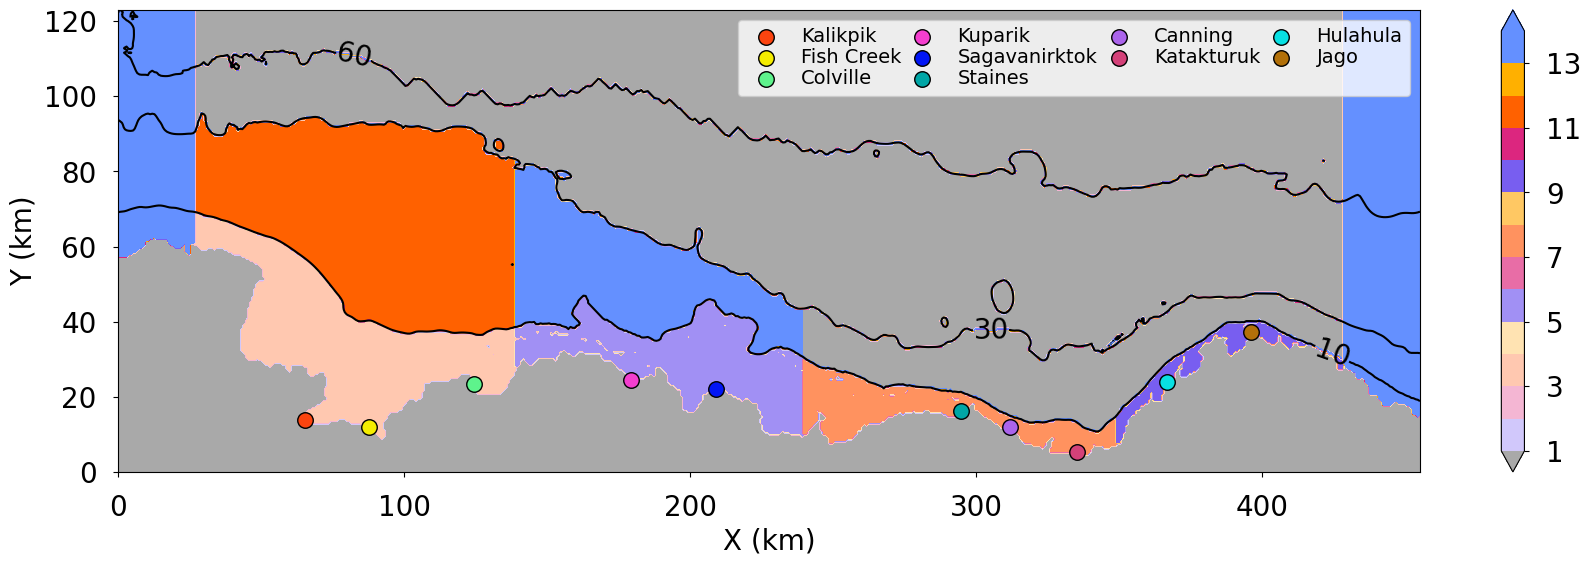

In [13]:
# Try to get just the seabed sections to work
# Plot this to make sure it worked
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap

# Plot all of this mayhem
# Make a fake xy with the right resolution to be able to plot without the angle
x_rho_flat = np.arange(0,750*len(grid.x_rho[0,:]),750)
y_rho_flat = np.arange(0,600*len(grid.y_rho[:,0]),600)
# Prep the data by  ultiplying by the mask and trimming
# Trim 
x_rho_flat_trimmed = x_rho_flat[c_west:-c_west]

# Set the fontsize 
fontsize = 20

# Set the levels 
lev11 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# Set the colormap
#cmap11 = cm.get_cmap('tab20', 14)
#cmap11.set_under(color='darkgrey')
cmap11 = LinearSegmentedColormap.from_list('seabed_sections', colors=seabed_section_colors, N=13)
cmap11.set_under(color='darkgrey')

# Make the plot
fig11, ax11 = plt.subplots(figsize=(21,6))

# Plot the bathymetry
cs11 = ax11.contour(x_rho_flat/1000, y_rho_flat/1000, grid.h.values, levels=[10,30,60], 
            colors='black', label=True)
ax11.clabel(cs11, inline=True, fontsize=20)

# Plot region 1 [0 - 10 m, across all longitudes]
cp37 = ax11.contourf(x_rho_flat/1000, y_rho_flat/1000, mask_0_10m_rho_plot2*grid.mask_rho.values, 
                   lev11, cmap=cmap11, extend='both')

# Plot region 2 [10 - 30 m, across all longitudes]
cp38 = ax11.contourf(x_rho_flat/1000, y_rho_flat/1000, mask_10_30m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 3 [30 - 60 m, across all longitudes]
cp39 = ax11.contourf(x_rho_flat/1000, y_rho_flat/1000, mask_30_60m_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Plot region 4 [60 - end, across all longitudes]
cp40 = ax11.contourf(x_rho_flat/1000, y_rho_flat/1000, mask_60_end_rho_plot2*grid.mask_rho.values, 
                     lev11, cmap=cmap11)

# Make the colorbar (numbers/values mean the region)
cbar11 = plt.colorbar(cp37, extend='both')

# Plot the 14 rivers in the grid
# Go from West to East
# Kalikpik River
eta_kal_idx = 23 #22
xi_kal_idx = 87
s1 = ax11.scatter(x_rho_flat[xi_kal_idx]/1000, y_rho_flat[eta_kal_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

# Fish Creek
eta_fis_idx = 20
xi_fis_idx = 117 #116
s2 = ax11.scatter(x_rho_flat[xi_fis_idx]/1000, y_rho_flat[eta_fis_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

# Colville River
eta_col_idx = 39
xi_col_idx = 166 #166
s3 = ax11.scatter(x_rho_flat[xi_col_idx]/1000, y_rho_flat[eta_col_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

# Sakonowyak River
eta_sak_idx = 46 #45
xi_sak_idx = 234
#s4 = ax11.scatter(x_rho_flat[xi_sak_idx]/1000, y_rho_flat[eta_sak_idx]/1000, 
 #           marker='.', s=500, linewidth=1, edgecolors='black', color='green', label='Sakonowyak')

# Kuparik
# Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
# of the Kuparuk River
eta_kuk_idx = 41 #40
xi_kuk_idx = 239
eta_kup_idx = 41 #40
xi_kup_idx = 242
s5 = ax11.scatter(x_rho_flat[xi_kuk_idx]/1000, y_rho_flat[eta_kuk_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')

# Kuparuk - commented out to move dot onto old Kukpuk since that is the main 
# channel of the Kuparuk 
#s6 = ax7[3].scatter(x_rho_flat_trimmed[xi_kup_idx]/1000, y_rho_flat[eta_kup_idx]/1000, 
 #           marker='.', s=500, linewidth=1, edgecolors='black', color='pink', label='Kuparuk')


# Fawn Creek
#eta_faw_idx = 44 #43
#xi_faw_idx = 249
#s7 = ax3[1].scatter(x_rho_flat[xi_faw_idx]/1000, y_rho_flat[eta_faw_idx]/1000, 
 #           marker='.', s=500, linewidth=1, edgecolors='black', color='darkviolet', label='Fawn Creek')

# Putuligayuk River
eta_put_idx = 28 #27
xi_put_idx = 264
#s8 = ax11.scatter(x_rho_flat[xi_put_idx]/1000, y_rho_flat[eta_put_idx]/1000, 
 #           marker='1', s=500, linewidth=1, edgecolors='black', color='dodgerblue', label='Putuligayuk')

# Sagavanirktok River
eta_sag_idx = 37 #36
xi_sag_idx = 279
s9 = ax11.scatter(x_rho_flat[xi_sag_idx]/1000, y_rho_flat[eta_sag_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

# Canning River
# Staines River
eta_sta_idx = 27 #26
xi_sta_idx = 393
s10 = ax11.scatter(x_rho_flat[xi_sta_idx]/1000, y_rho_flat[eta_sta_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

# Canning River
eta_can_idx = 20 #19
xi_can_idx = 416
s11 = ax11.scatter(x_rho_flat[xi_can_idx]/1000, y_rho_flat[eta_can_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

# Katakturuk River
eta_kat_idx = 9 #8
xi_kat_idx = 447
s12 = ax11.scatter(x_rho_flat[xi_kat_idx]/1000, y_rho_flat[eta_kat_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

# Hulahula River
eta_hul_idx = 40
xi_hul_idx = 489
s13 = ax11.scatter(x_rho_flat[xi_hul_idx]/1000, y_rho_flat[eta_hul_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

# Jago River
eta_jag_idx = 62 #61
xi_jag_idx = 528
s14 = ax11.scatter(x_rho_flat[xi_jag_idx]/1000, y_rho_flat[eta_jag_idx]/1000, 
            marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')

# Siksik River
eta_sik_idx = 46
xi_sik_idx = 574 #573
#s15 = ax11.scatter(x_rho_flat[xi_sik_idx]/1000, y_rho_flat[eta_sik_idx]/1000, 
 #           marker='.', s=300, linewidth=4, color='deeppink', label='Siksik')

# Temporary not too bad legend
ax11.legend(loc='upper right', ncol=4, fontsize=14, columnspacing=0.1, labelspacing=0.1)

# Label the axes
ax11.set_ylabel('Y (km)', fontsize=fontsize)
ax11.set_xlabel('X (km)', fontsize=fontsize)

In [14]:
mask_0_10m_rho_plot2

array([[14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]], shape=(206, 608))

In [15]:
# Make function/Call function to go through model output 
# and get average bed shear stress in 0 - 10 m depths as 
# function of longitude

# EDIT this to get the bed shear stres in these regions instead 

# Want time series of bed shear stress for all times and space

# Then get just the values in 0 - 10 m depths and take the mean over them
# Load in the model output
# Aggregated 
model_output = xr.open_mfdataset('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_000*.nc')

# Get time series of bed shear stress
bstr = model_output.bstrcwmax.values

# Take the mean over time
bstr_tavg = np.nanmean(bstr, axis=0)

# Loop through longitudes, find indces for 0 - 10 m, then
# take the mean over this region 

# In grid, loop through each xi_rho, then find distance between first cell 
# that is 1 in eta-direction and first cell in eta direction that is >= 10 m in h

# Make triggers 
if1 = 0
if2 = 0

# Make empty array to hold distances
avg_bstr_0_10m = np.empty_like((grid.xi_rho))

# Loop through xi
for i in range(len(grid.xi_rho)):
    print('i: ', i)
    
    # Loop through eta
    for j in range(len(grid.eta_rho)):
        
        # Find the first spot that has mask_rho = 1
        if grid.mask_rho[j,i].values == 2.0 and if1 == 0:
            #print('found 1 in mask at eta: ' + str(j) + ', xi: ' + str(i))
            
            j_land = j
            if1 = 1
        
        # Find the first spot that has bathyemtry >=10 
        if grid.h[j,i].values >= 10.0 and if2 == 0:
            #print('found 10 m bathymetry at eta: ' + str(j) + ', xi: ' + str(i))
            
            j_10m = j
            if2 = 1
    
    # Get the mean bed shear stress over this region 
    print('values: ', bstr_tavg[j_land:(j_10m+1), i])
    avg_bstr_tmp = np.nanmean(bstr_tavg[j_land:(j_10m+1), i])
    print('mean: ', avg_bstr_tmp)
    
    # Save this to the array
    avg_bstr_0_10m[i] = avg_bstr_tmp
    
    # Reset ifs
    if1 = 0
    if2 = 0






i:  0
values:  [0.26692094 0.27610085 0.28961194 0.30573805 0.31840227 0.33014623
 0.35365671 0.38156922 0.38095748 0.37972047 0.37524992 0.34484003
 0.32111578 0.29930952 0.27613741 0.25260276 0.23484698 0.2216856
 0.21161435 0.20371955 0.19124851]
mean:  0.2959616464981581
i:  1
values:  [0.26692094 0.27610085 0.28961194 0.30573805 0.31840227 0.33014623
 0.35365671 0.38156922 0.38095748 0.37972047 0.37524992 0.34484003
 0.32111578 0.29930952 0.27613741 0.25260276 0.23484698 0.2216856
 0.21161435 0.20371955 0.19124851]
mean:  0.2959616464981581
i:  2
values:  [0.20691893 0.23095305 0.26335265 0.29313993 0.28794697 0.312519
 0.33850096 0.36460729 0.36908631 0.36736642 0.36172387 0.346469
 0.32393141 0.30183263 0.27911605 0.25737622 0.23891271 0.2240193
 0.21187087 0.20136138 0.19321344]
mean:  0.2844865899698683
i:  3
values:  [0.18607839 0.21511427 0.23589959 0.25610121 0.27905431 0.30413564
 0.33049006 0.35725622 0.36811073 0.366119   0.36239317 0.35511933
 0.33435084 0.31276915 0.29

Text(0.975, 0.093, 'd)')

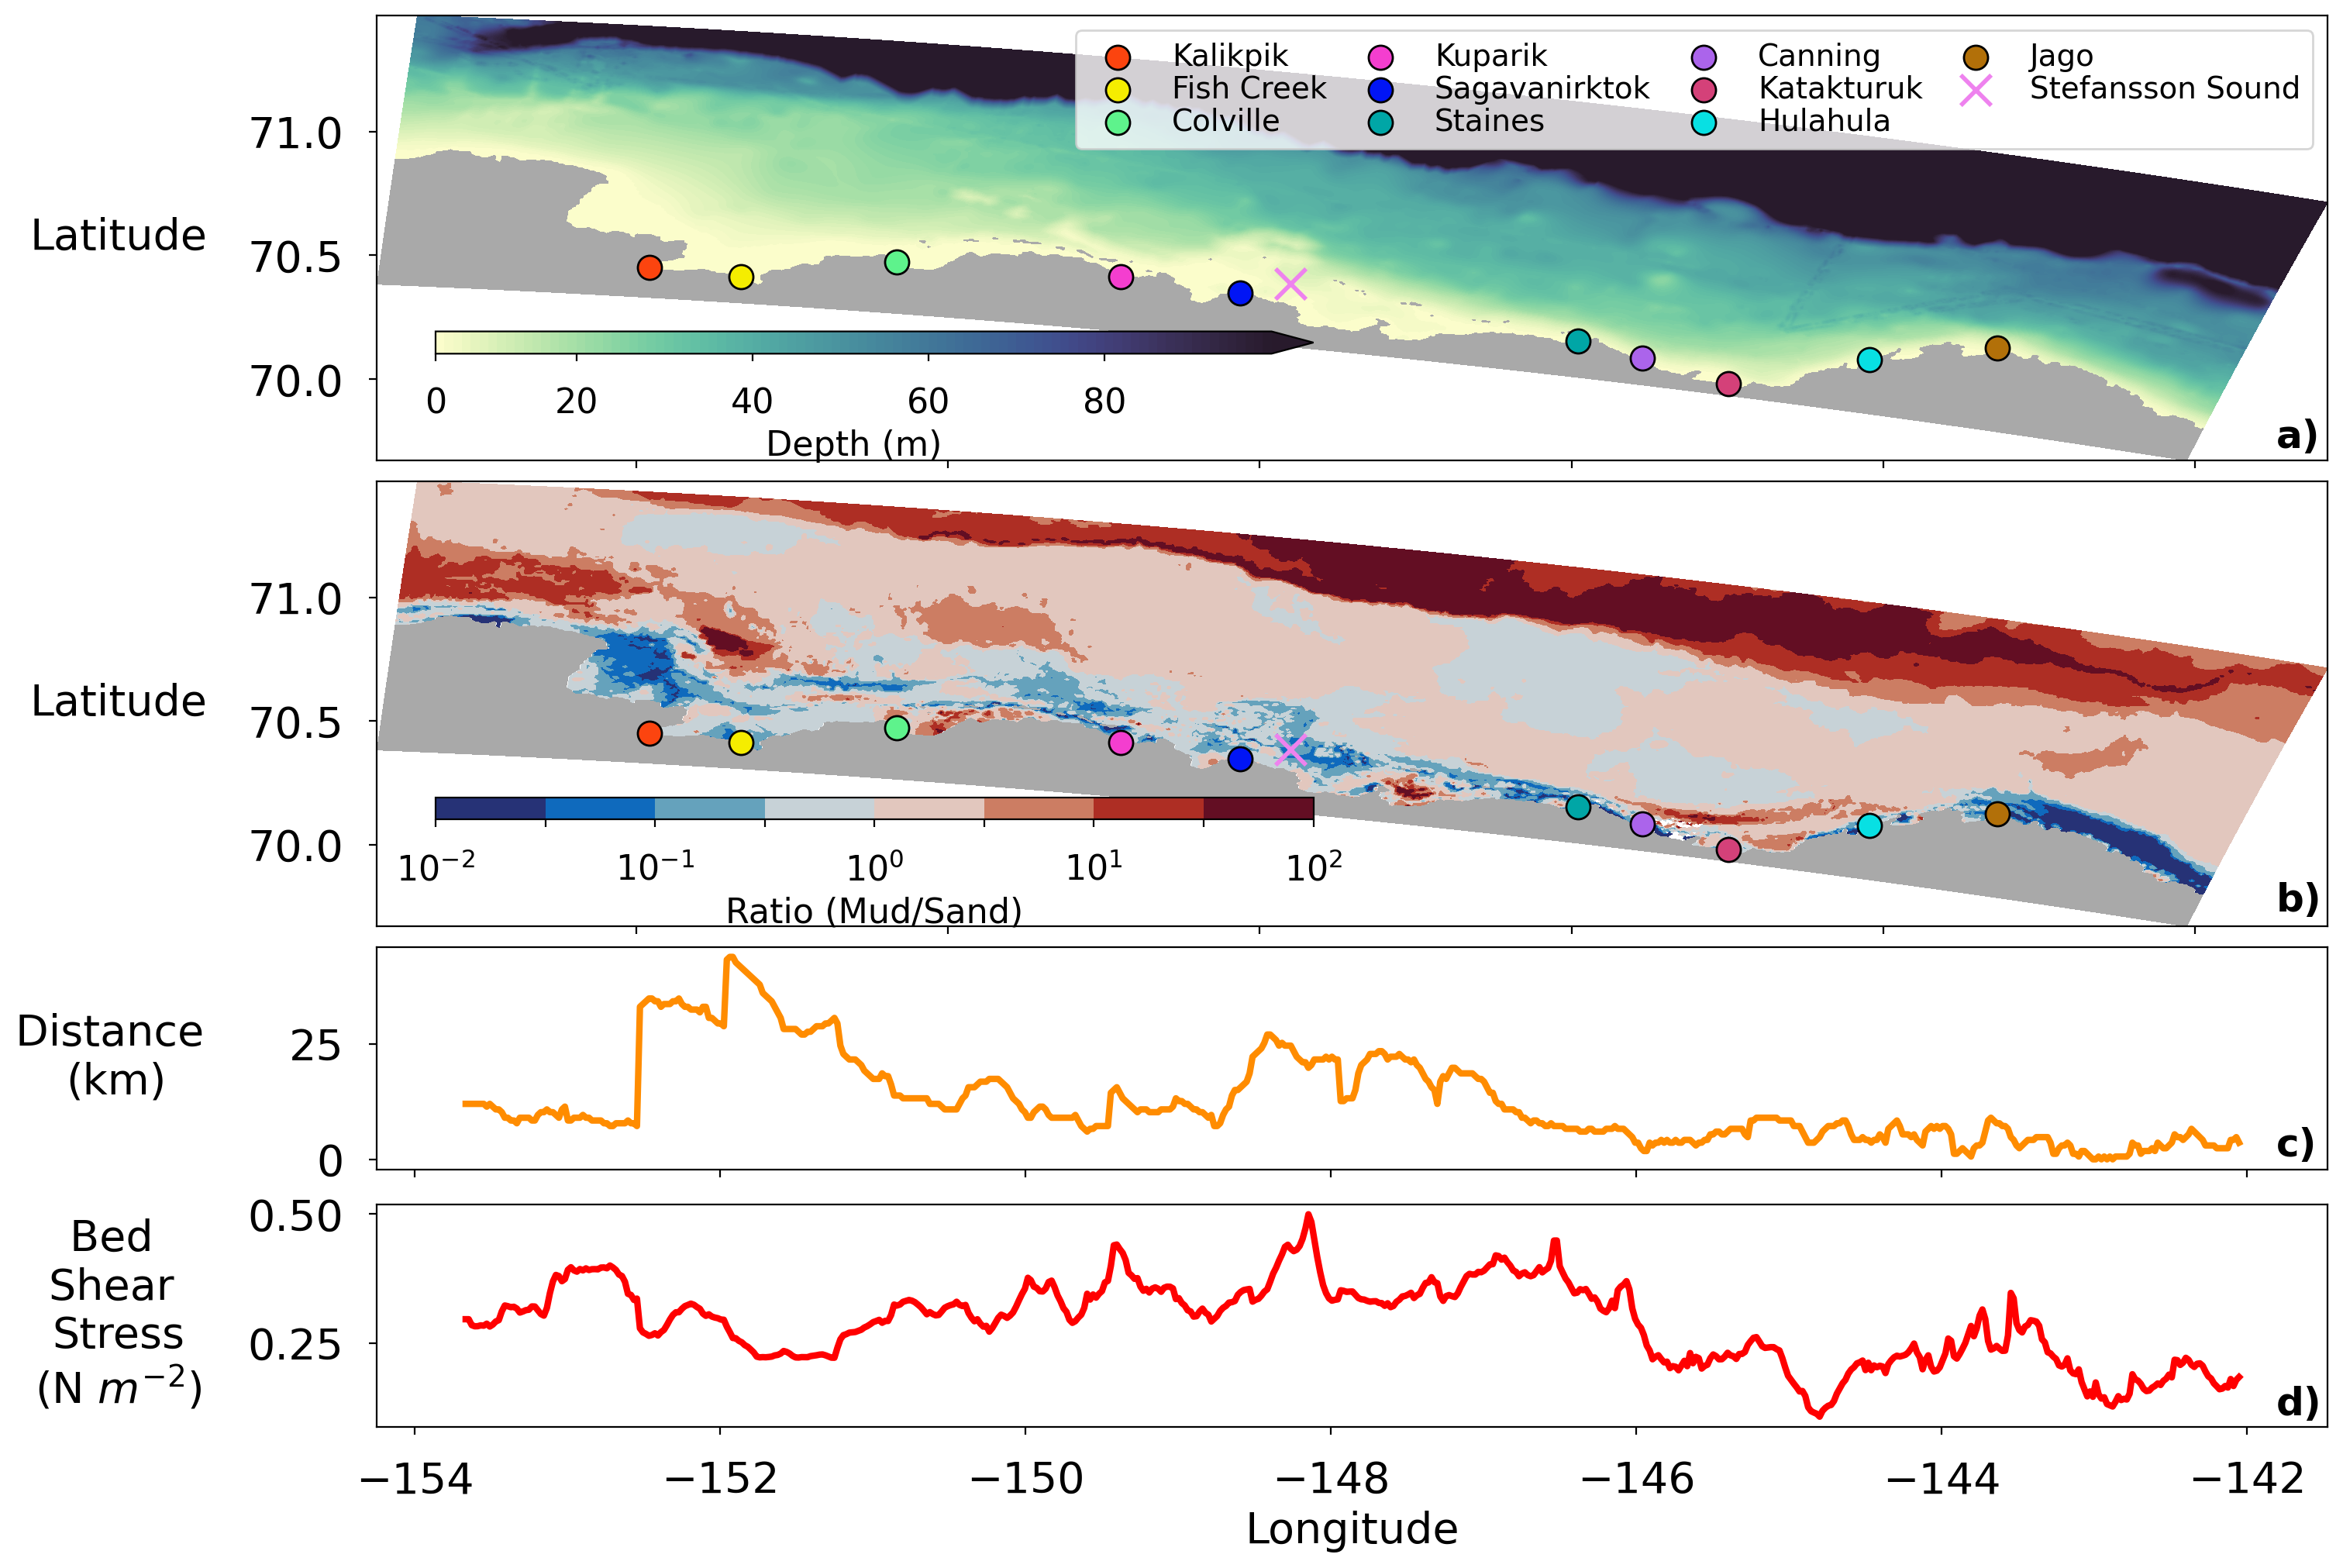

In [16]:
# Do a version of the plot that does not have the seabed sections
# Edit this to have all of the new projection stuff that I've done for the other plots
import matplotlib.gridspec as gridspec


# Make the figure
fig2, ax2 = plt.subplots(4, figsize=(15,10), gridspec_kw={'height_ratios': [1, 1, 0.5, 0.5]}, # (15,8)
                         dpi=200, constrained_layout=True) # (width, height), (15, 12) for horizontal colorbar; (20, 16) for vertical colorbaroutside plots

# ---- Replace specific axes with Cartopy projections ----
# Delete the first two default (plain) axes and recreate them with projections
#for i in [0, 1]:
 #   fig2.delaxes(ax2[i])
#ax2[0] = fig2.add_subplot(3, 1, 1, projection=crs)
#ax2[1] = fig2.add_subplot(3, 1, 2, projection=crs)  # example: different projection


# ----- Top Subplot: Bathymetry and Rivers -----
# Plot the bathymetry
cs8 = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev6, cmap=cmap7, extend='max', projection=crs)
cs9 = ax2[0].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray', projection=crs)

# Plot land as gray 
cs0g = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm, projection=crs)

# Format axes
#ax1[0].set_xlabel('Longitude (degrees)', fontsize=fontsize)
ax2[0].set_ylabel('Latitude \n(degrees)', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118

# Specify colorbar
#cbar3 = fig3.colorbar(cs6, label='Depth (m)', orientation='vertical', ax=ax3)
#cbar3.set_label(label='Depth (meters)', size=fontsize)
# If horizontal and in axes
# Top right
# cbar5 = plt.colorbar(cs8, cax=ax2[0].inset_axes((0.55, 0.92, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
#                      ticks=[0, 20, 40, 60, 80], ax=ax2[0], 
#                      orientation='horizontal')
# Bottom left
cbar5 = plt.colorbar(cs8, cax=ax2[0].inset_axes((0.03, 0.24, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
                     ticks=[0, 20, 40, 60, 80], ax=ax2[0], 
                     orientation='horizontal')
cbar5.set_label(label='Depth (m)', size=fontsize-4, color='black')
cbar5.ax.tick_params(labelcolor='black', labelsize=fontsize-4)
# If adding background to tick labels and colorbar labels 
# cbar5.ax.xaxis.label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))
# # Tick label backgrounds
# for label in cbar5.ax.get_xticklabels():
#     label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=1))

# ----- Middle Subplot: Fraction of Mud/Sand -----
#ax2b = fig2.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
# Determine spacing of contours
lev7 = np.arange(-0.00001, 1, 0.01)
cmap4 = cmocean.cm.turbid
cmap4.set_under('darkgray')

lev8 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

lev9 = np.arange(0,2,0.01)

# Plot bathymetry contours
# Plot the bathymetry
cs9 = ax2[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev7, colors='dimgray', projection=crs)
# Plot land as gray 
cs0g = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm, projection=crs)

#cs10 = ax1[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values*grid.mask_rho.values, lev8, colors='dimgray')

# Plot the percent mud
#cs11 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_mud_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Mud')

# Plot the percent sand
#cs12 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_sand_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Sand')

# Plot the ratio 
cmap5 = cmocean.cm.balance
cmap5.set_under('darkgray')
cmap5.set_bad('darkgray')

ratio_mud_over_sand = (tot_mud_percent_wland/tot_sand_percent_wland)

# Get rid of zeros before logging
no_inf1 = np.where(ratio_mud_over_sand == 0, 10**-1.5, ratio_mud_over_sand)

# Mask land
#ratio_mud_over_sand_wland = ratio_mud_over_sand * temp_mask
ratio_mud_over_sand_wland = no_inf1 * temp_mask
#input('press enter...')

# Get rid of nans
#ratio_mud_over_sand_wland = ratio_mud_over_sand_wland.fillna(-1.5)

# Get rid of infinity 
no_inf2 = np.where(ratio_mud_over_sand_wland == np.inf, 40, ratio_mud_over_sand_wland)

# No log scale
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, ratio_mud_over_sand_wland[0,0,:,:], lev9,
 #                     cmap=cmap5, extend='both', label='Ratio')
 
# Log of actual values
lev13 = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
log_ratio = np.log10(no_inf2[0,0,:,:])
log_ratio2 = np.nan_to_num(log_ratio, nan=-3)
# Works but might be wrong since real values are -2 to 2
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, log_ratio2, 
 #                     lev13, cmap=cmap5,  vmin=-2.0, vmax=2.0, extend='both', label='Ratio')
# Try plotting just the ratio but on a log scale 
lev13b = [10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 10**(0), 10**(0.5), 10**(1), 10**(1.5), 10**(2)]
cs13 = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, no_inf2[0,0,:,:], 
                      lev13b, cmap=cmap5, locator=LogLocator(base=10), vmin=10**(-2), 
                      vmax=10**(2), label='Ratio', projection=crs)

# Log scale
# Data as log
# Top right
#cbar6 = fig2.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax2[1], 
 #                     cax=ax2[1].inset_axes((0.55, 0.92, 0.45, 0.05)), extend='both')
# Bottom left
cbar6 = fig2.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax2[1], 
                      cax=ax2[1].inset_axes((0.03, 0.24, 0.45, 0.05)), extend='both')
cbar6.set_label(label='Ratio (Mud/Sand)', size=fontsize-4, color='black')
cbar6.ax.tick_params(labelcolor='black', labelsize=fontsize-4)


# Loop through axes and add rivers
for t in range(2):
    #ax2 = [ax2a, ax2b]
    # Plot the 10 rivers in the grid
    # Go from West to East
    # Kalikpik River
    s1 = ax2[t].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

    # Fish Creek
    s2 = ax2[t].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

    # Colville River
    s3 = ax2[t].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    s5 = ax2[t].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')

    # Sagavanirktok River
    s9 = ax2[t].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

    # Canning River
    # Staines River
    s10 = ax2[t].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

    # Canning River
    s11 = ax2[t].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

    # Katakturuk River
    s12 = ax2[t].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

    # Hulahula River
    s13 = ax2[t].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

    # Jago River
    s14 = ax2[t].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')
    
    # Plot Stefansson Sound
    # Set the indices
    eta_boulder_idx = 47
    xi_boulder_idx = 294
    ax2[t].scatter(grid.lon_rho[eta_boulder_idx, xi_boulder_idx].values, grid.lat_rho[eta_boulder_idx, xi_boulder_idx].values, 
                    marker='x', s=200, linewidth=2, edgecolors='violet', color='violet', label='Stefansson Sound')
    
# Add a legend for all the rivers
# Temporary not too bad legend
#ax2[0].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)
ax2[0].legend(loc='upper right', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)
    
# Add the bottom panel of the distances
#ax2[2].sharex(ax2[0])
ax2[2].plot(grid.lon_rho[0,:].values, dist_to_10m/1000, linewidth=3, color='darkorange')
ax2[2].set_ylabel('Distance \n(km)', fontsize=fontsize, rotation=0, labelpad=80, va='center')

# Add plot of average bed shear stress 
ax2[3].plot(grid.lon_rho[0,:].values, avg_bstr_0_10m, linewidth=3, color='red')
ax2[3].set_ylabel('Bed \nShear \nStress' + '\n' + r'(N $m^{-2}$)', fontsize=fontsize, rotation=0, labelpad=60, va='center')


# Mute x-axis labels on middle plots
plt.setp(ax2[0].get_xticklabels(), visible=False)
plt.setp(ax2[1].get_xticklabels(), visible=False)
plt.setp(ax2[2].get_xticklabels(), visible=False)
#plt.setp(ax2[2].get_xticklabels(), visible=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.05) #0.08 # (0.22, 0.25)

# Temporary not too bad legend
#ax1[2].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.1, labelspacing=0.1)

# Label the axes
ax2[0].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[1].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[3].set_xlabel('Longitude', fontsize=fontsize)


# Add subplot labels
fig2.text(0.975, 0.717, 'a)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.418, 'b)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.260, 'c)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.093, 'd)', color='black', fontsize=fontsize-2, weight='bold')

Text(0.975, 0.093, 'd)')

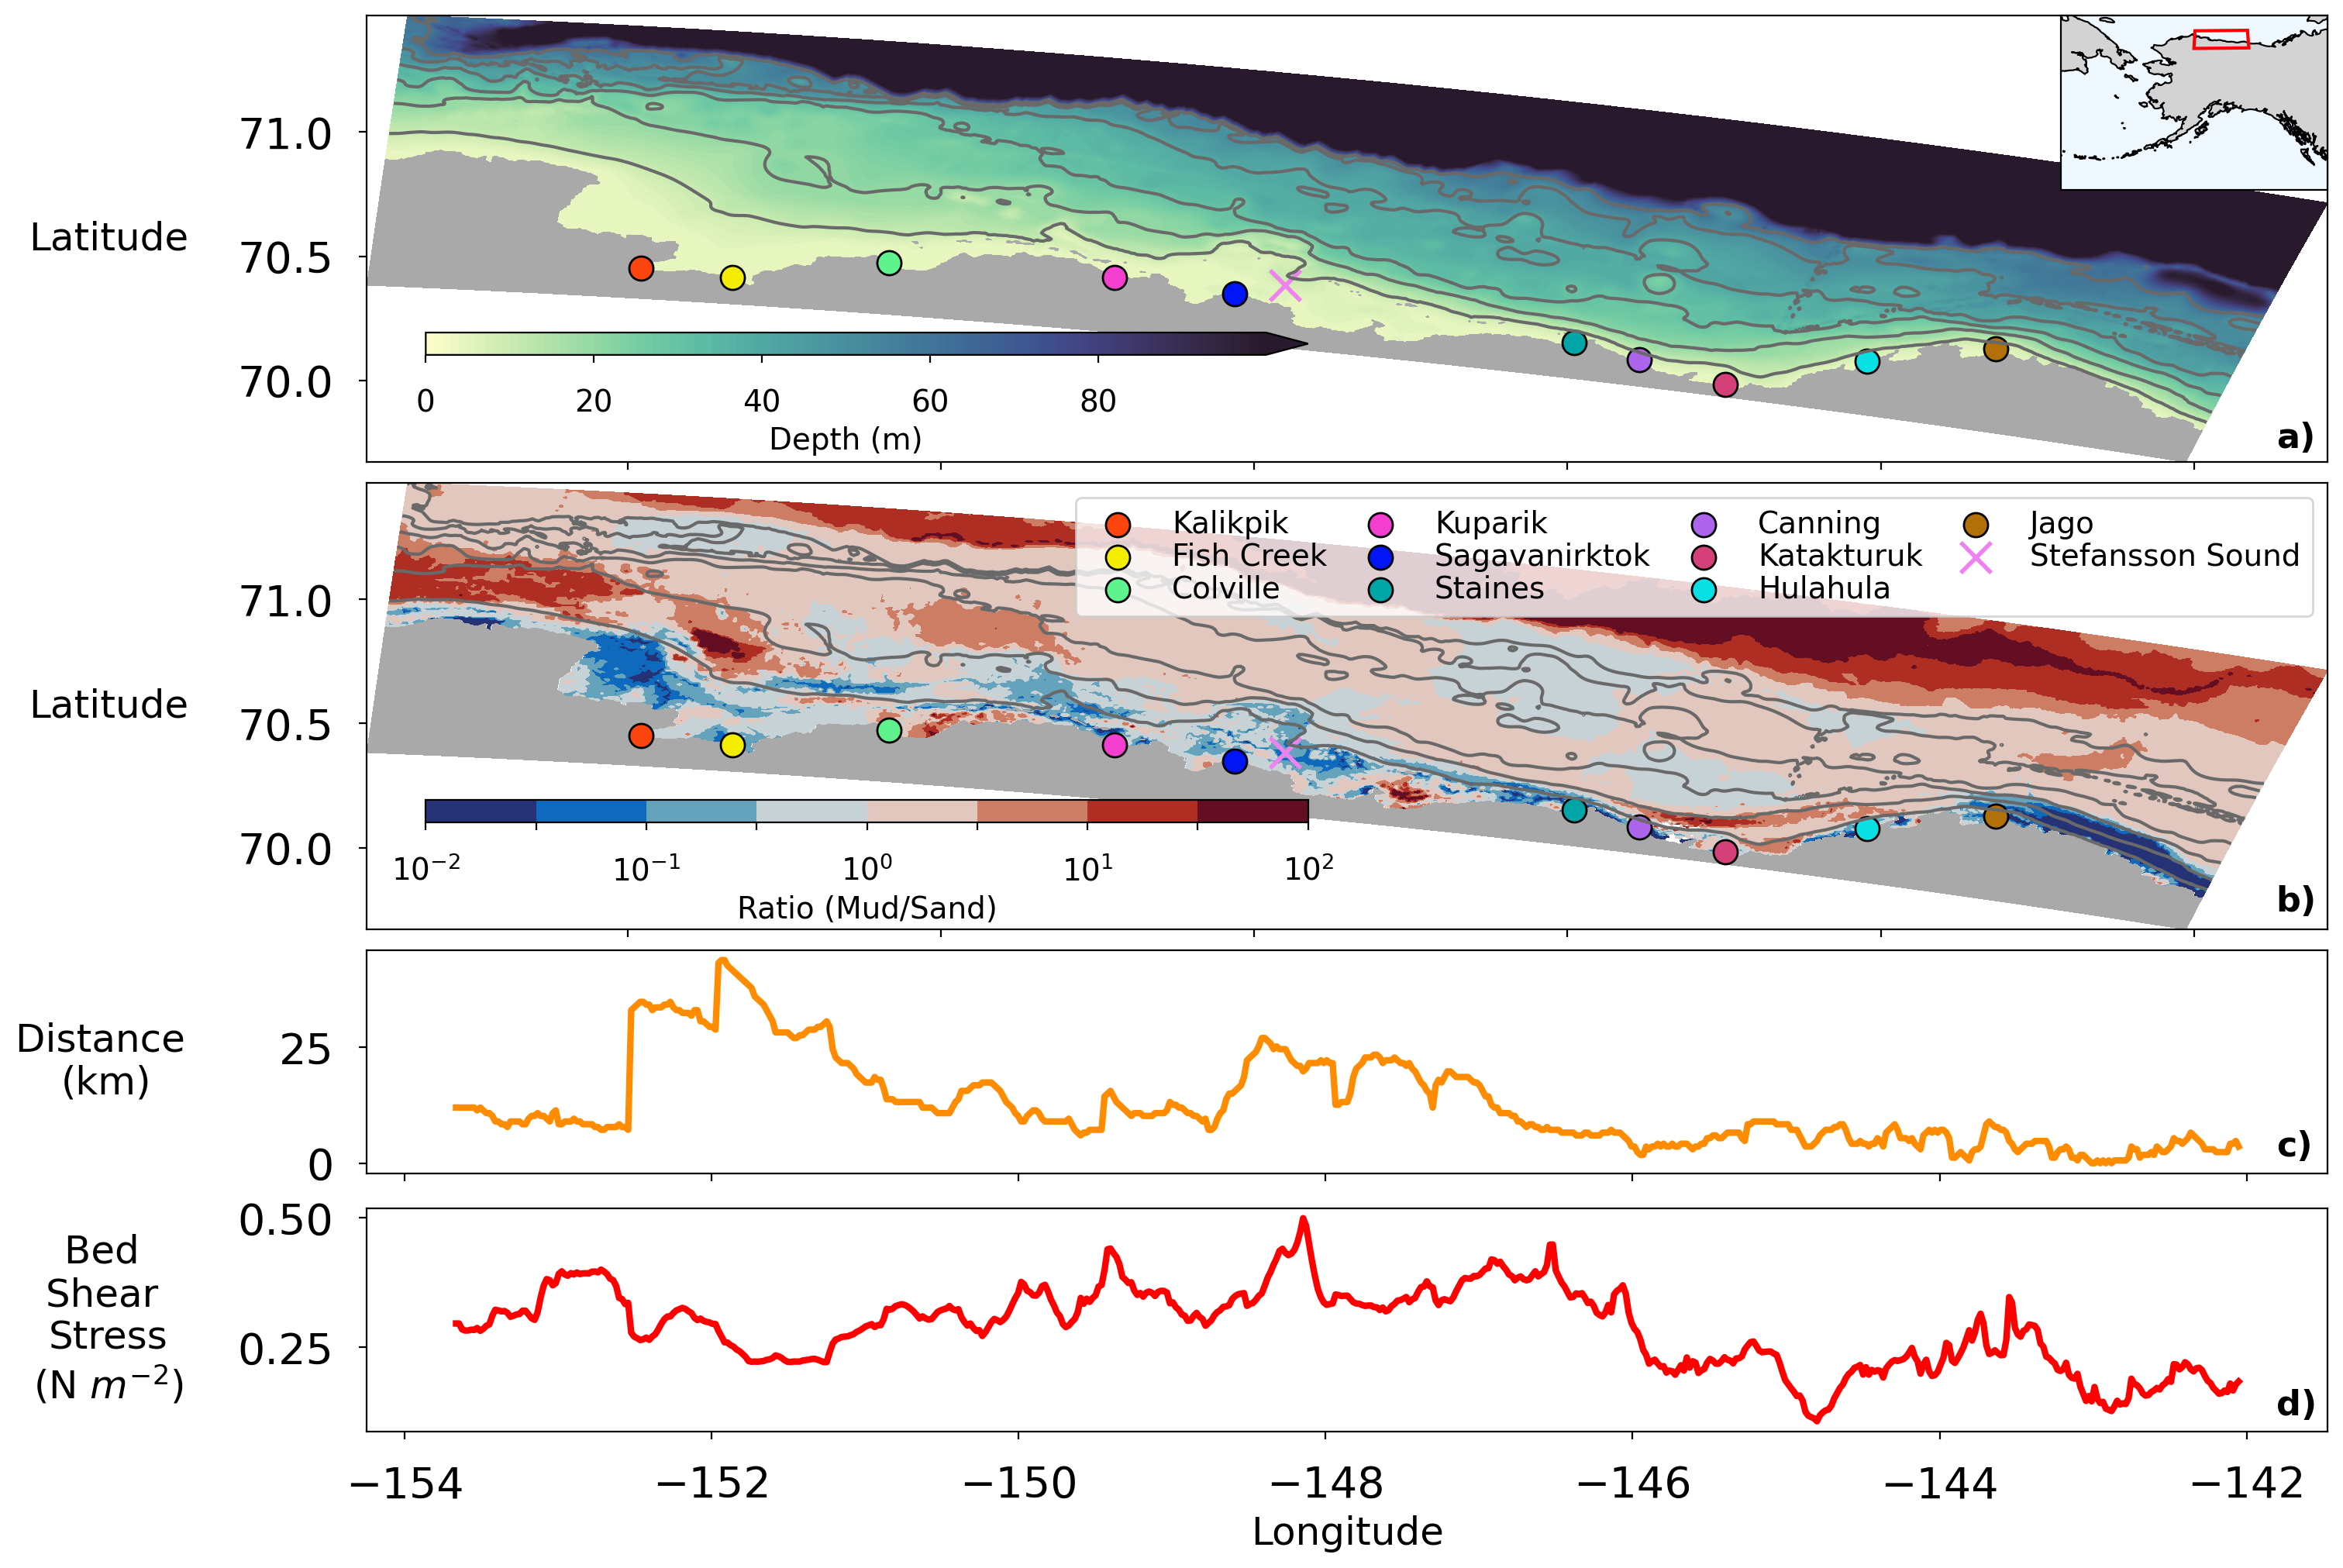

In [38]:
# Edit the above plot to have an Alaska inset and 
# bathymetry contours for the maps 
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

# Set the levels
lev_bathy = np.arange(0,101,1)
lev_bathy2 = np.arange(0,70,10)

# Make the figure
fig2, ax2 = plt.subplots(4, figsize=(15,10), gridspec_kw={'height_ratios': [1, 1, 0.5, 0.5]}, # (15,8)
                         dpi=200, constrained_layout=True) # (width, height), (15, 12) for horizontal colorbar; (20, 16) for vertical colorbaroutside plots


# ----- Top Subplot: Bathymetry and Rivers -----
# Plot the bathymetry
cs8 = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev_bathy, cmap=cmap7, extend='max', projection=crs)
cs9 = ax2[0].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev_bathy2, colors='dimgray', projection=crs)

# Plot land as gray 
cs0g = ax2[0].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm, projection=crs)

# Format axes
#ax1[0].set_xlabel('Longitude (degrees)', fontsize=fontsize)
ax2[0].set_ylabel('Latitude \n(degrees)', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118

# Specify colorbar
#cbar3 = fig3.colorbar(cs6, label='Depth (m)', orientation='vertical', ax=ax3)
#cbar3.set_label(label='Depth (meters)', size=fontsize)
# If horizontal and in axes
# Top right
# cbar5 = plt.colorbar(cs8, cax=ax2[0].inset_axes((0.55, 0.92, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
#                      ticks=[0, 20, 40, 60, 80], ax=ax2[0], 
#                      orientation='horizontal')
# Bottom left
cbar5 = plt.colorbar(cs8, cax=ax2[0].inset_axes((0.03, 0.24, 0.45, 0.05)),      #(0.38, 0.92, 0.6, 0.05)
                     ticks=[0, 20, 40, 60, 80], ax=ax2[0], 
                     orientation='horizontal')
cbar5.set_label(label='Depth (m)', size=fontsize-4, color='black')
cbar5.ax.tick_params(labelcolor='black', labelsize=fontsize-4)
# If adding background to tick labels and colorbar labels 
# cbar5.ax.xaxis.label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))
# # Tick label backgrounds
# for label in cbar5.ax.get_xticklabels():
#     label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=1))

# --- Alaska Inset Map (Top Right of Top Panel) ---
# Define Alaska inset projection
alaska_proj = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=63)

# Create the inset directly inside the top axes (ax2[0])
# (x0, y0, width, height) are in *axes coordinates*, so 1.0 = right/top edge
ax_inset = ax2[0].inset_axes([0.747, 0.61, 0.37, 0.39], projection=alaska_proj)  # [0.68, 0.60, 0.28, 0.30] | end at 1.104 (x) and 1 (y)
# ↑ adjust numbers slightly to shift or resize

# Set extent for all of Alaska
ax_inset.set_extent([-180, -129, 50, 72], crs=ccrs.PlateCarree())

# Add base map features
ax_inset.add_feature(cfeature.LAND, color='lightgray', zorder=0)
ax_inset.add_feature(cfeature.OCEAN, color='aliceblue', zorder=0)
ax_inset.coastlines(resolution='50m', linewidth=0.8)

# --- Add red rectangle showing zoomed region ---
lon_min, lon_max = -156, -142
lat_min, lat_max = 69, 72
rect = Rectangle((lon_min, lat_min),
                 lon_max - lon_min, lat_max - lat_min,
                 facecolor='none', edgecolor='red', linewidth=1.5,
                 transform=ccrs.PlateCarree(), zorder=5)
ax_inset.add_patch(rect)

# Optional: make the inset tidy
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_frame_on(True)

# ----- Middle Subplot: Fraction of Mud/Sand -----
#ax2b = fig2.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
# Determine spacing of contours
lev7 = np.arange(-0.00001, 1, 0.01)
cmap4 = cmocean.cm.turbid
cmap4.set_under('darkgray')

lev8 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

lev9 = np.arange(0,2,0.01)

# Plot bathymetry contours
# Plot the bathymetry
cs9 = ax2[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values, lev_bathy2, colors='dimgray', projection=crs)
# Plot land as gray 
cs0g = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, mask_rho2, cmap=reverse_colors, norm=norm, projection=crs)

#cs10 = ax1[1].contour(grid.lon_rho.values, grid.lat_rho.values, grid.h[:,:].values*grid.mask_rho.values, lev8, colors='dimgray')

# Plot the percent mud
#cs11 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_mud_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Mud')

# Plot the percent sand
#cs12 = ax1[1].contourf(grid.lon_rho.values, grid.lat_rho.values, tot_sand_percent_wland[0,0,:,:], lev7, 
 #                     cmap=cmap4, extend='both', label='Sand')

# Plot the ratio 
cmap5 = cmocean.cm.balance
cmap5.set_under('darkgray')
cmap5.set_bad('darkgray')

ratio_mud_over_sand = (tot_mud_percent_wland/tot_sand_percent_wland)

# Get rid of zeros before logging
no_inf1 = np.where(ratio_mud_over_sand == 0, 10**-1.5, ratio_mud_over_sand)

# Mask land
#ratio_mud_over_sand_wland = ratio_mud_over_sand * temp_mask
ratio_mud_over_sand_wland = no_inf1 * temp_mask
#input('press enter...')

# Get rid of nans
#ratio_mud_over_sand_wland = ratio_mud_over_sand_wland.fillna(-1.5)

# Get rid of infinity 
no_inf2 = np.where(ratio_mud_over_sand_wland == np.inf, 40, ratio_mud_over_sand_wland)

# No log scale
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, ratio_mud_over_sand_wland[0,0,:,:], lev9,
 #                     cmap=cmap5, extend='both', label='Ratio')
 
# Log of actual values
lev13 = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
log_ratio = np.log10(no_inf2[0,0,:,:])
log_ratio2 = np.nan_to_num(log_ratio, nan=-3)
# Works but might be wrong since real values are -2 to 2
#cs13 = ax4[2].contourf(grid.lon_rho.values, grid.lat_rho.values, log_ratio2, 
 #                     lev13, cmap=cmap5,  vmin=-2.0, vmax=2.0, extend='both', label='Ratio')
# Try plotting just the ratio but on a log scale 
lev13b = [10**(-2), 10**(-1.5), 10**(-1), 10**(-0.5), 10**(0), 10**(0.5), 10**(1), 10**(1.5), 10**(2)]
cs13 = ax2[1].contourf(grid.lon_rho.values, grid.lat_rho.values, no_inf2[0,0,:,:], 
                      lev13b, cmap=cmap5, locator=LogLocator(base=10), vmin=10**(-2), 
                      vmax=10**(2), label='Ratio', projection=crs)

# Log scale
# Data as log
# Top right
#cbar6 = fig2.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax2[1], 
 #                     cax=ax2[1].inset_axes((0.55, 0.92, 0.45, 0.05)), extend='both')
# Bottom left
cbar6 = fig2.colorbar(cs13, label='Ratio (Mud/Sand)', orientation='horizontal', ax=ax2[1], 
                      cax=ax2[1].inset_axes((0.03, 0.24, 0.45, 0.05)), extend='both')
cbar6.set_label(label='Ratio (Mud/Sand)', size=fontsize-4, color='black')
cbar6.ax.tick_params(labelcolor='black', labelsize=fontsize-4)


# Loop through axes and add rivers
for t in range(2):
    #ax2 = [ax2a, ax2b]
    # Plot the 10 rivers in the grid
    # Go from West to East
    # Kalikpik River
    s1 = ax2[t].scatter(grid.lon_rho[eta_kal_idx, xi_kal_idx].values, grid.lat_rho[eta_kal_idx, xi_kal_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[0], label='Kalikpik')

    # Fish Creek
    s2 = ax2[t].scatter(grid.lon_rho[eta_fis_idx, xi_fis_idx].values, grid.lat_rho[eta_fis_idx, xi_fis_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[1], label='Fish Creek')

    # Colville River
    s3 = ax2[t].scatter(grid.lon_rho[eta_col_idx, xi_col_idx].values, grid.lat_rho[eta_col_idx, xi_col_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[2], label='Colville')

    # Kuparik
    # Kukpuk - Change this to be labeled as the Kuparuk since it  is actually the main channel 
    # of the Kuparuk River
    s5 = ax2[t].scatter(grid.lon_rho[eta_kuk_idx, xi_kuk_idx].values, grid.lat_rho[eta_kuk_idx, xi_kuk_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[4], label='Kuparik')

    # Sagavanirktok River
    s9 = ax2[t].scatter(grid.lon_rho[eta_sag_idx, xi_sag_idx].values, grid.lat_rho[eta_sag_idx, xi_sag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[6], label='Sagavanirktok')

    # Canning River
    # Staines River
    s10 = ax2[t].scatter(grid.lon_rho[eta_sta_idx, xi_sta_idx].values, grid.lat_rho[eta_sta_idx, xi_sta_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[7], label='Staines')

    # Canning River
    s11 = ax2[t].scatter(grid.lon_rho[eta_can_idx, xi_can_idx].values, grid.lat_rho[eta_can_idx, xi_can_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[8], label='Canning')

    # Katakturuk River
    s12 = ax2[t].scatter(grid.lon_rho[eta_kat_idx, xi_kat_idx].values, grid.lat_rho[eta_kat_idx, xi_kat_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[9], label='Katakturuk')

    # Hulahula River
    s13 = ax2[t].scatter(grid.lon_rho[eta_hul_idx, xi_hul_idx].values, grid.lat_rho[eta_hul_idx, xi_hul_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[10], label='Hulahula')

    # Jago River
    s14 = ax2[t].scatter(grid.lon_rho[eta_jag_idx, xi_jag_idx].values, grid.lat_rho[eta_jag_idx, xi_jag_idx].values, 
                marker='.', s=500, linewidth=1, edgecolors='black', color=river_marker_colors[11], label='Jago')
    
    # Plot Stefansson Sound
    # Set the indices
    eta_boulder_idx = 47
    xi_boulder_idx = 294
    ax2[t].scatter(grid.lon_rho[eta_boulder_idx, xi_boulder_idx].values, grid.lat_rho[eta_boulder_idx, xi_boulder_idx].values, 
                    marker='x', s=200, linewidth=2, edgecolors='violet', color='violet', label='Stefansson Sound')
    
# Add a legend for all the rivers
# Temporary not too bad legend
#ax2[0].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)
ax2[1].legend(loc='upper right', ncol=4, fontsize=14, columnspacing=0.75, labelspacing=0.1)
    
# Add the bottom panel of the distances
#ax2[2].sharex(ax2[0])
ax2[2].plot(grid.lon_rho[0,:].values, dist_to_10m/1000, linewidth=3, color='darkorange')
ax2[2].set_ylabel('Distance \n(km)', fontsize=fontsize, rotation=0, labelpad=80, va='center')

# Add plot of average bed shear stress 
ax2[3].plot(grid.lon_rho[0,:].values, avg_bstr_0_10m, linewidth=3, color='red')
ax2[3].set_ylabel('Bed \nShear \nStress' + '\n' + r'(N $m^{-2}$)', fontsize=fontsize, rotation=0, labelpad=60, va='center')


# Mute x-axis labels on middle plots
plt.setp(ax2[0].get_xticklabels(), visible=False)
plt.setp(ax2[1].get_xticklabels(), visible=False)
plt.setp(ax2[2].get_xticklabels(), visible=False)
#plt.setp(ax2[2].get_xticklabels(), visible=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.05) #0.08 # (0.22, 0.25)

# Temporary not too bad legend
#ax1[2].legend(loc='lower left', ncol=4, fontsize=14, columnspacing=0.1, labelspacing=0.1)

# Label the axes
ax2[0].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[1].set_ylabel('Latitude', fontsize=fontsize, rotation=0, labelpad=60, va='center') #118
ax2[3].set_xlabel('Longitude', fontsize=fontsize)


# Add subplot labels
fig2.text(0.975, 0.717, 'a)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.418, 'b)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.260, 'c)', color='black', fontsize=fontsize-2, weight='bold')
fig2.text(0.975, 0.093, 'd)', color='black', fontsize=fontsize-2, weight='bold')

In [18]:
model_output.bstrcwmax

<xarray.DataArray 'bstrcwmax' (ocean_time: 781, eta_rho: 206, xi_rho: 608)> Size: 783MB
dask.array<concatenate, shape=(781, 206, 608), dtype=float64, chunksize=(43, 206, 608), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 1MB dask.array<chunksize=(206, 608), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 1MB dask.array<chunksize=(206, 608), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 6kB 2020-07-01T01:00:00 ... 2020-...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  max wave and current bottom stress magnitude
    units:      newton meter-2
    time:       ocean_time
    grid:       grid
    location:   face
    field:      bstrcwmax, scalar, series

In [19]:
q = np.arange(0, 10, 1)
print(q)
print(q[0:5])
print(np.mean(q[0:5]))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4]
2.0


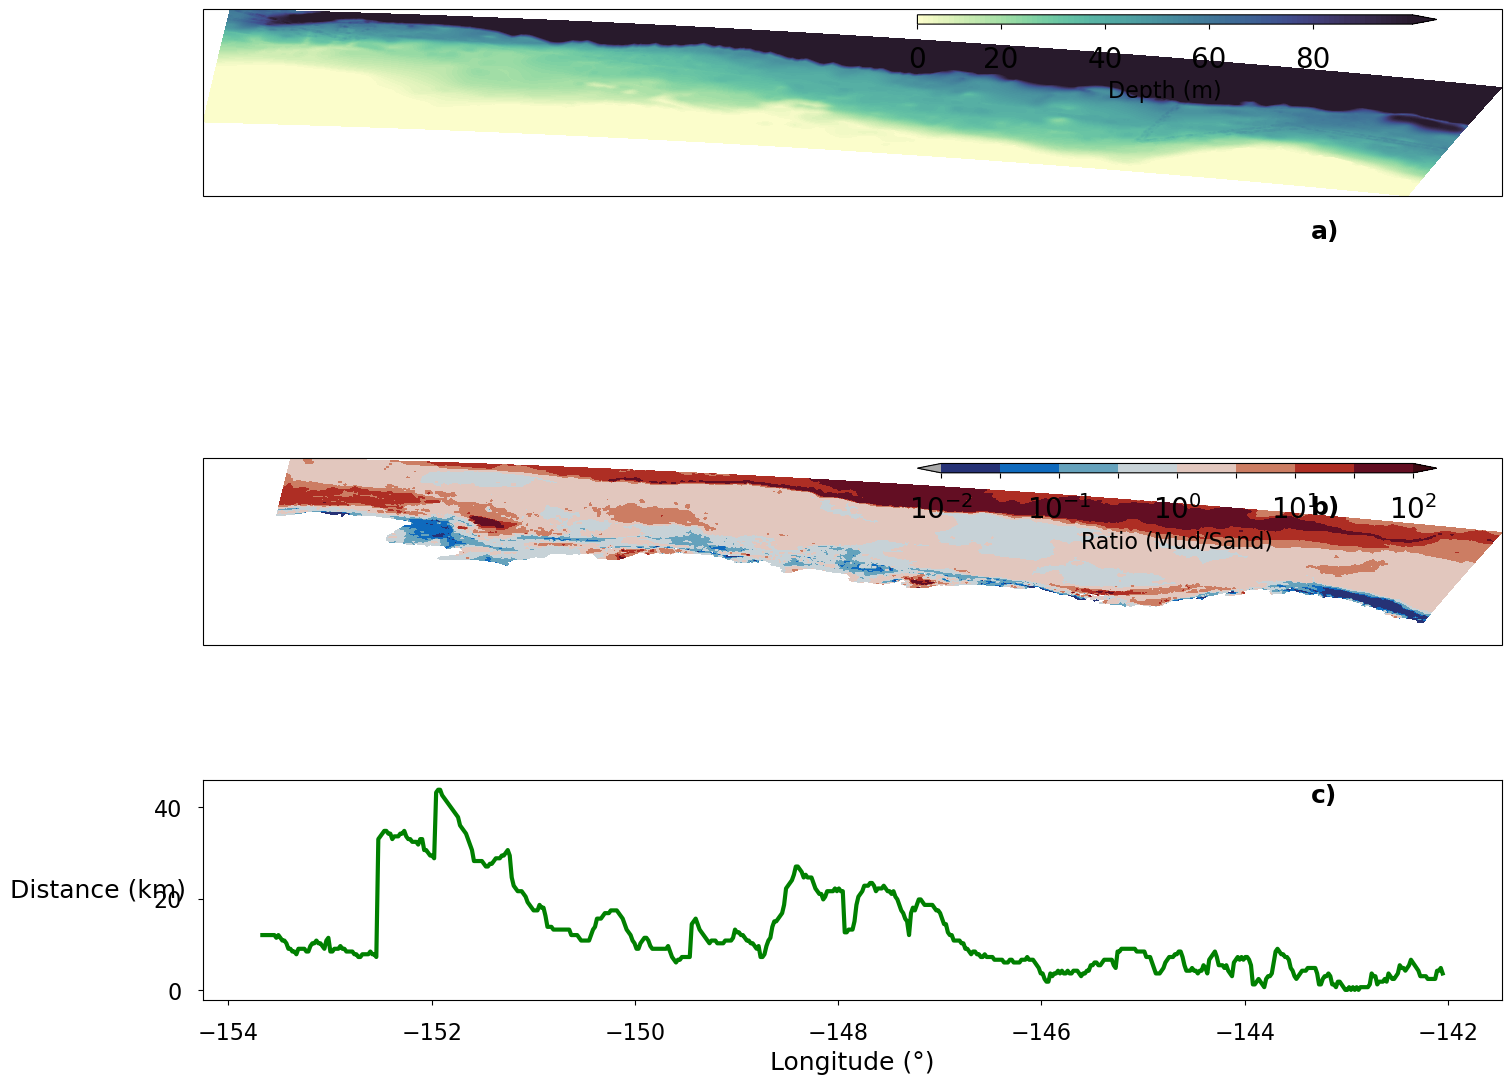

In [20]:
# chatGPT version 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

fontsize = 18

# ----- Set up figure and GridSpec -----
fig2 = plt.figure(figsize=(15, 12), constrained_layout=True)
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 0.5], figure=fig2)

# =========================
# TOP PANEL: Bathymetry
# =========================
ax2a = fig2.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
cs8 = ax2a.contourf(grid.lon_rho, grid.lat_rho, grid.h, lev6, cmap=cmap7, extend='max')
ax2a.contour(grid.lon_rho, grid.lat_rho, grid.h, lev7, colors='dimgray')

# Colorbar
cax_a = ax2a.inset_axes([0.55, 0.92, 0.4, 0.05])
cbar_a = fig2.colorbar(cs8, cax=cax_a, orientation='horizontal', ticks=[0, 20, 40, 60, 80])
cbar_a.set_label('Depth (m)', size=fontsize-2)

# Labels
ax2a.set_ylabel('Latitude (°)', fontsize=fontsize, rotation=0, labelpad=40, va='center')


# =========================
# MIDDLE PANEL: Mud/Sand Ratio
# =========================
ax2b = fig2.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
cs13 = ax2b.contourf(
    grid.lon_rho, grid.lat_rho, no_inf2[0,0,:,:],
    lev13b, cmap=cmap5, locator=LogLocator(base=10),
    vmin=10**(-2), vmax=10**2, extend='both'
)
cax_b = ax2b.inset_axes([0.55, 0.92, 0.4, 0.05])
cbar_b = fig2.colorbar(cs13, cax=cax_b, orientation='horizontal')
cbar_b.set_label('Ratio (Mud/Sand)', size=fontsize-2)

ax2b.set_ylabel('Latitude (°)', fontsize=fontsize, rotation=0, labelpad=40, va='center')

# Hide overlapping x labels
ax2a.set_xticklabels([])
ax2b.set_xticklabels([])


# =========================
# BOTTOM PANEL: Distance Plot
# =========================
ax2c = fig2.add_subplot(gs[2, 0])
ax2c.plot(grid.lon_rho[0,:], dist_to_10m/1000, linewidth=3, color='green')

ax2c.set_xlabel('Longitude (°)', fontsize=fontsize)
ax2c.set_ylabel('Distance (km)', fontsize=fontsize, rotation=0, labelpad=40, va='center')


# =========================
# Global layout adjustments
# =========================
for ax in [ax2a, ax2b, ax2c]:
    ax.tick_params(labelsize=fontsize-2)

# Add subplot labels (a–c)
label_positions = [(0.87, 0.70), (0.87, 0.47), (0.87, 0.23)]
for label, (x, y) in zip(['a)', 'b)', 'c)'], label_positions):
    fig2.text(x, y, label, fontsize=fontsize, fontweight='bold', transform=fig2.transFigure)

plt.show()
